In [2]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm, mstats
from datetime import datetime, date, timedelta, timezone
import edge
import edge.edge_mean_reversion as emr
import edge.edge_risk_kit as erk
import TMRW
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf

today = date.today() 
today = datetime(today.year,today.month,today.day) #today
m1 = datetime(today.year,today.month-1,today.day)
m3 = datetime(today.year,today.month-3,today.day)
m6 = datetime(today.year,today.month-5,today.day)
one = datetime(today.year-1,today.month,today.day) #one year ago
three = datetime(today.year-3,today.month,today.day) #one year ago
five = datetime(today.year-5,today.month,today.day) #one year ago

CUR = pd.read_excel(open('E:/Investering/Currencies.xlsx', 'rb'),sheet_name='Currencies')
CUR = list(CUR[CUR['BSYMBOL'].notnull()]['SYMBOL'])
lste = CUR
fee = 0.000715

import warnings
warnings.filterwarnings("ignore")


import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as sa
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, date, timedelta, timezone
import yfinance as yf
from scipy import integrate
import random

import pandas_ta as ta

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from xgboost import XGBClassifier

import TMRW

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# IMPORTS
import pandas as pd
import numpy as np

import time
import math
import os.path

# from tqdm import tnrange, notebook
from tqdm.notebook import tqdm

from datetime import timedelta, datetime
from dateutil import parser

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator

import seaborn as sns
sns.set()

import edge

import edge.edge_mean_reversion as a
import edge.edge_risk_kit as erk

import yfinance as yf
from datetime import datetime, date, timedelta, timezone

import pandas as pd
import numpy as np

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator

import seaborn as sns
sns.set()

In [2]:
def mk_test(ts, mode = 'simple', window = 50, alpha = 0.00001):
    """
    Mann-Kendall test for trend
    Detects linear trends (in pair with cox_stuart)
    Optimal window = 50

    Input:
        x:   a vector of data
        alpha: significance level (0.001 default)
        window: last n values, for finding trend
        mode: 
            - 'full' - if you need to know trend direction; 
            - 'simple' - if just trend existance.

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics 

    """
    x = ts[-window:]
    n = len(x)

    # calculate S 
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])
    #s = [-1 if x[j] < x[k] else 1 for j in xrange(k+1,n) for k in xrange(n-1)]

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)
    # calculate the var(s)
    n = float(n)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
        #print (var_s)
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test

    h = abs(z) > norm.ppf(1-alpha/2) 

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    if mode == 'full':
        return trend, h, p, z
    else:
        return h, abs(z)


def cox_stuart(timeseries, window = 50, alpha = 0.0001, debug = False):
    """
    Cox-Stuart criterion
    H0: trend exists
    H1: otherwise

    Detects linear trends
    Optimal window = 50
    """
    n = window
    idx = np.arange(1,n+1)
    X = pandas.Series(timeseries[-n:], index=idx)
    
    S1 = [(n-2*i) if X[i] <= X[n-i+1] else 0 for i in range(1,n//2)]
    n = float(n)
    S1_ = (sum(S1) - n**2 / 8) / math.sqrt(n*(n**2-1)/24)
    u = norm.ppf(1-alpha/2)
    if debug:
        print ('|S1*|:', abs(S1_))
        print ("u:",u)
    
    return abs(S1_) > u, abs(S1_) #H0 accept

def abbe_criterion(timeseries, window = 40, alpha = .00001, debug = False):

    """
    Abbe-Linnik criterion
    Detects exponential trend (in pair with autocorrelation)
    If window >50 => too much True
    """
    if len(timeseries) < window:
        return False
    series = pandas.Series(timeseries)
    a = series[-window:]
    mean = a.mean()
    

    X = zip(a[:-1],a[1:])
    s1 = sum([math.pow((x[0]-x[1]),2) for x in X])
    s2 = sum([pow((x-mean),2) for x in a])
    q = 0.5 * s1 / s2
    q_a = 0.6814
    n = len(a)
    Q = -(1-q)*math.sqrt((2*n+1)/(2-pow((1-q),2)))
    u = norm.ppf(alpha) #kobzar page 26
    if debug:
        print ('mean:', mean)
        print ('q:', q)
        print ('Q*:', Q)
        print ('U_alpha-1:', u)
    return Q < u, abs(Q)


def autocorrelation(timeseries, window = 50, alpha = .00001, debug = False):
    """
    Detects exponential trend

    """
    n = window
    idx = np.arange(1,n+1)
    series = pandas.Series(list(timeseries[-n:]), index=idx)

    X = zip(series[:-1],series[1:])
    sqr_sum = pow(sum(series),2)
    n_f = float(n)
    r = (n_f * sum([x[0]*x[1] for x in X]) - sqr_sum + n_f*series[1]*series[n]) / \
        (n_f * sum([x**2 for x in series]) - sqr_sum)
    
    r_ = abs(r + 1./(n_f-1.)) / math.sqrt(n_f*(n_f-3)/(n_f+1)/pow((n_f-1),2))
    u = norm.ppf(1-alpha/2)
    
    return abs(r_) > u, abs(r_)

# for hver invertering af MA5 og MA21. Hvor lang tid går der så indtil vi rammer samme pris som inverteringsprisen?
def mr_times(data):

    lstma5_times = []

    for i in range(1, len(data)):

        if (data.iloc[i,17] > data.iloc[i,3] and data.iloc[i-1,17] <= data.iloc[i-1,3]):
            lstma5_times.append(i)
        elif (data.iloc[i,17] < data.iloc[i,3] and data.iloc[i-1,17] >= data.iloc[i-1,3]):
            lstma5_times.append(i)

    lst1 = []
    for i in range(1, len(lstma5_times)):
        lst1.append(lstma5_times[i] - lstma5_times[i-1])


    lstma21_times = []

    for i in range(1, len(data)):

        if (data.iloc[i,27] > data.iloc[i,3] and data.iloc[i-1,27] < data.iloc[i-1,3]):
            lstma21_times.append(i)
        elif (data.iloc[i,27] < data.iloc[i,3] and data.iloc[i-1,27] > data.iloc[i-1,3]):
            lstma21_times.append(i)

    lst2 = []
    for i in range(1, len(lstma21_times)):
        lst2.append(lstma21_times[i] - lstma21_times[i-1])
        
    return([lst1,lst2])

def ed(data, bins = 10):

    bine = np.linspace(min(data), max(data), bins)
    counts = []

    for i in range(0,len(bine)):

        bine[i] = round(bine[i],3)
        count = 0

        for j in range(len(data)):

            if data.iloc[j] >= bine[i-1] and data.iloc[j] < bine[i]:

                count = count + 1

        counts.append(count/len(data))

    counts_df = pd.DataFrame(counts, index = bine)
    return(counts_df)

In [3]:
def corr_coint(data):
    correlations = data.corr()


    co_int = pd.DataFrame("", columns = data.columns, index = data.columns)

    for i in range(len(data.columns)):

        for j in range(len(data.columns)):

            if a.perform_coint_test(data.iloc[:,i], data.iloc[:,j], False)[1] == False:
                co_int.iloc[i,j] = "False"
            elif a.perform_coint_test(data.iloc[:,i], data.iloc[:,j], False)[1] == True:
                co_int.iloc[i,j] = "True"

    couplings = []
    for i in range(len(co_int.columns)):
        for j in range(len(co_int)):

            if i!=j:
                if co_int.iloc[j,i] == "True" and correlations.iloc[j,i] > 0.8:
                    couplings.append([co_int.columns[i], co_int.index[j]])
    return(couplings)

def corr_coint_list(lste, fra, til):
    prices = pd.DataFrame()

    for i in range(len(lste)):
        prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']

    prices = prices.fillna(0)

    lst = []
    for i in range(len(prices.columns)):
        if np.mean(prices.iloc[:,i]) == 0:
            lst.append(i)

    prices = prices.drop(prices.columns[lst], axis=1)

    returns = prices.pct_change()#.dropna()
    returns = returns.iloc[1:len(returns),:]
    returns.replace([np.inf, -np.inf], 0, inplace=True)
    returns = returns.fillna(0)

    prices_list = corr_coint(prices)
    returns_list = corr_coint(returns)

    lst = []
    for i in returns_list:
        for j in prices_list:
            if i == j:
                lst.append(i)
    return(lst)

def stat_test(fra, til, lste, typ, win):
    
    prices = pd.DataFrame()

    for i in range(len(lste)):
        prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']

    prices = prices.fillna(0)

    lst = []
    for i in range(len(prices.columns)):
        if np.mean(prices.iloc[:,i]) == 0:
            lst.append(i)

    prices = prices.drop(prices.columns[lst], axis=1)

    returns = prices.pct_change()#.dropna()
    returns = returns.iloc[1:len(returns),:]
    returns.replace([np.inf, -np.inf], 0, inplace=True)
    returns = returns.fillna(0)

    if typ == "prices":
        data = prices
    elif typ == "returns":
        data = returns
    
    df = []
    for i in range(len(data.columns)):
        if a.perform_adf_test(data.iloc[:,i])[2] == True:
            b = "Stationary"
        else:
            b = "Non-stationary"

        if a.perform_variance_ratio_test(data.iloc[:,i])[1] == True:
            c = "Random walk"
        else:
            c = "Not Random walk"

        if a.perform_hurst_exp_test(data.iloc[:,i])[0] < 0.25:
            d = "Mean reverting"
        elif a.perform_hurst_exp_test(data.iloc[:,i])[0] > 0.75:
            d = "Trending"
        else:
            d = "None"

        adf = adfuller(data.iloc[:,i], 1)

        if adf[1] < 0.2 and adf[0] > (adf[4]['10%'] - adf[4]['1%'])/adf[4]['1%'] * 20: 
            d_ = "Mean reverting"

        elif adf[1] < 0.1 and adf[0] > adf[4]['10%']:
            d_ = "not mean reverting"

        elif (adf[0] > dict(adf[4])['1%']) and (adf[0] > dict(adf[4])['5%']) and (adf[0] > dict(adf[4])['10%']):
            d_ = "not mean reverting"

        else:
            d_ = "Mean reverting"

        if mk_test(data.iloc[:,i], mode = 'simple', window = win, alpha = 0.05)[0] == False:
            e = "Non-Trending"
        elif mk_test(data.iloc[:,i], mode = 'simple', window = win, alpha = 0.05)[0] == True:
            e = "Trending"

        if cox_stuart(data.iloc[:,i], window = win, alpha = 0.00005)[0] == False:
            f = "Non-Trending"
        elif cox_stuart(data.iloc[:,i], window = win, alpha = 0.00005)[0] == True:
            f = "Trending"

        if abbe_criterion(data.iloc[:,i], window = win, alpha = 0.00005)[0] == False:
            g = "Non-Trending"
        elif abbe_criterion(data.iloc[:,i], window = win, alpha = 0.00005)[0] == True:
            g = "Trending"

        if autocorrelation(data.iloc[:,i], window = win, alpha = 0.0001)[0] == False:
            h = "Non-Trending"
        elif autocorrelation(data.iloc[:,i], window = win, alpha = 0.0001)[0] == True:
            h = "Trending"



        df.append([prices.columns[i],b,c,d,d_,e,f,g,h])
    df = pd.DataFrame(df, columns = ['Symbol', 'Stationarity', 'Randomwalk(yes/no)', 'Hurst Exponent', 'ADfuller test', 'MK test', 'Cox Stuart', 'Abbe Criterion', 'Autocorrelation'])
    return(df)

In [ ]:
def markov_table(data, typ = "above close", length = "3", probsa = True):
    
    if typ == "under close":
        data = data[data['MA21_ind'] == 1] # ma21 is below close
    elif typ == "above close":
        data = data[data['MA21_ind'] == -1] # ma21 is above close

    if length == "3":
        indx = pd.DataFrame(data['UD3indicator'].unique()).sort_values(by = 0, ascending=False)
        indx = indx.reset_index(drop = True)
        
        lst = []
        for i in list(indx[0]):

            a = data[data['UD3indicator'] == i]
            b = a[a['velocity'] >= 0]
            c = a[a['velocity'] < 0]
            lst.append([len(b),len(c), len(a)])
        
        probs = pd.DataFrame(lst, index = indx[0], columns = ['UP', 'DOWN', 'SUM'])
        
    elif length == "5":
        indx =pd.DataFrame(data['UD5indicator'].unique()).sort_values(by = 0, ascending=False)
        indx = indx.reset_index(drop = True)
        probs = pd.DataFrame(0.0, index = indx[0], columns = ['UP', 'DOWN', 'SUM'])
        
        lst = []
        for i in list(indx[0]):

            a = data[data['UD5indicator'] == i]
            b = a[a['velocity'] >= 0]
            c = a[a['velocity'] < 0]
            lst.append([len(b),len(c), len(a)])
        
        probs = pd.DataFrame(lst, index = indx[0], columns = ['UP', 'DOWN', 'SUM'])
        
        
    if probsa == True:
        probs['UP'] = probs['UP'] / probs['SUM']
        probs['DOWN'] = probs['DOWN'] / probs['SUM']
    return(probs)


def volume_weighted_velocity(data, window = 21):

    v_w_vel = 0
    lst = np.zeros(window)
    lst = list(lst)
    for i in range(window, len(data)):
        v_sum = sum(data2['Volume'][i-window:i])
        v_w_vel = 0
        for j in range(window):
            v_w_vel = v_w_vel + data2['velocity'][i-j] * (data2['Volume'][i-j] / v_sum)

        lst.append(v_w_vel)
    return(lst)

def volume_weighted_mean(data, window = 21):

    v_w_vel = 0
    lst = np.zeros(window)
    lst = list(lst)
    for i in range(window, len(data)):
        v_sum = sum(data2['Volume'][i-window:i])
        v_w_vel = 0
        for j in range(window):
            v_w_vel = v_w_vel + data2['Close'][i-j] * (data2['Volume'][i-j] / v_sum)

        lst.append(v_w_vel)
    return(lst)

# -*- coding: utf-8 -*-

import math
import numpy as np
import pandas
from scipy.stats import norm, mstats

def markov_table(data, typ = "above close", length = "3", probsa = True):
    
    if typ == "under close":
        data = data[data['MA21_ind'] == 1] # ma21 is below close
    elif typ == "above close":
        data = data[data['MA21_ind'] == -1] # ma21 is above close

    if length == "3":
        indx = pd.DataFrame(data['UD3indicator'].unique()).sort_values(by = 0, ascending=False)
        indx = indx.reset_index(drop = True)
        
        lst = []
        for i in list(indx[0]):

            a = data[data['UD3indicator'] == i]
            b = a[a['velocity'] >= 0]
            c = a[a['velocity'] < 0]
            lst.append([len(b),len(c), len(a)])
        
        probs = pd.DataFrame(lst, index = indx[0], columns = ['UP', 'DOWN', 'SUM'])
        
    elif length == "5":
        indx =pd.DataFrame(data['UD5indicator'].unique()).sort_values(by = 0, ascending=False)
        indx = indx.reset_index(drop = True)
        probs = pd.DataFrame(0.0, index = indx[0], columns = ['UP', 'DOWN', 'SUM'])
        
        lst = []
        for i in list(indx[0]):

            a = data[data['UD5indicator'] == i]
            b = a[a['velocity'] >= 0]
            c = a[a['velocity'] < 0]
            lst.append([len(b),len(c), len(a)])
        
        probs = pd.DataFrame(lst, index = indx[0], columns = ['UP', 'DOWN', 'SUM'])
        
        
    if probsa == True:
        probs['UP'] = probs['UP'] / probs['SUM']
        probs['DOWN'] = probs['DOWN'] / probs['SUM']
    return(probs)

def bollinger_bands(data, length):
    mean_lst = np.zeros(len(data))
    std_lst = np.zeros(len(data))
    for i in range(0, length):
        mean_lst[i] = data[i]
        std_lst[i] = 0.05 * data[i]
    
    for i in range(length,len(data)):
        mean_lst[i] = np.mean(data[i-length:i])
        std_lst[i] = np.std(data[i-length:i])
        
    up = mean_lst + 2.5 * std_lst
    down = mean_lst - 2.5 * std_lst
    
    boll = pd.DataFrame()
    boll['Upper'] = up
    boll['Lower'] = down
    return(boll)




def mean_sizes(data, t):
    
    sizes = moving_averages(data, t)
    for i in range(len(sizes)):
        
        for j in range(len(sizes.columns)):
            
            sizes.iloc[i,j] = data.iloc[i] - sizes.iloc[i,j] 
            
    return(sizes)

def mean_size_dist(data, t):
    
    ms = mean_sizes(data,t)
    msd = pd.DataFrame(0, index = ['upper+2s', 'upper-m', 'upper-2s','lower+2s','lower-m','lower-2s'], columns = ms.columns)
    for ti in range(1, len(ms.columns)):
        
        msp = ms[ti+1][ms[ti+1] > 0]
        msn = ms[ti+1][ms[ti+1] < 0]
        
        msd[ti+1]['upper+2s'] = np.mean(msp) + 2 * np.std(msp)
        msd[ti+1]['upper-m'] = np.mean(msp)
        msd[ti+1]['upper-2s'] = min(msp)
        
        msd[ti+1]['lower+2s'] = max(msn)
        msd[ti+1]['lower-m'] = np.mean(msn)
        msd[ti+1]['lower-2s'] = np.mean(msn) - 2 * np.std(msn)
        
    return(msd)
        
def mean_times(data, t):
    ms = mean_sizes(data, t)
    mrt = pd.DataFrame(index = ["mrt"], columns = ms.columns)
    for i in range(len(ms.columns)):
        n = 0
        for j in range(len(ms)):
            if ms.iloc[j,i] > 0 and ms.iloc[j-1,i] < 0:
                n = n + 1
            elif ms.iloc[j,i] < 0 and ms.iloc[j-1,i] > 0:
                n = n + 1
            else:
                n = n
        mrt[i+1]['mrt'] = len(ms) / (n+1)
    return(mrt)      

# Covariance, Correlation, Collinearity

In [2]:
df = pd.DataFrame()
n = 100
mat = []
h = TMRW.DATA.data(lste[0],m6,today)['Close']
for i in range(len(lste[0:n])):
    df[lste[i]] = TMRW.DATA.data(lste[i],m6,today)['Close'].shift(-1)

df.replace([np.inf, -np.inf], 0, inplace=True)
df = df.fillna(0)
lst = []
for i in range(len(df.columns)):
    if np.mean(df.iloc[:,i]) == 0:
        lst.append(i)

df = df.drop(df.columns[lst], axis=1)

df['BTC-USD'] = h

for i in range(len(lste[0:n])):
    a = np.cov(df.iloc[:,0],df.iloc[:,i])[1,0] # covariance mellem XYZ og BTC
    b = np.corrcoef(df.iloc[:,0],df.iloc[:,i])[1,0] # Correlation mellem XYZ og BTC
    c = variance_inflation_factor(df, i) # Collinearity mellem XYZ og BTC
    mat.append([lste[i],a,b,c])
    
matrice1d = pd.DataFrame(mat, columns = ["Symbol", "Covariance", "Correlation", "Collinearity"])    
m1d = matrice1d[matrice1d['Correlation'] > 0.70]

# Linearity

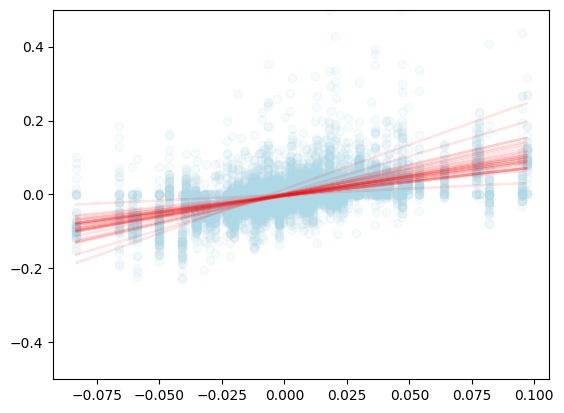

1.1068070568693211
-0.0009933602309142638
0.4294414918785609
0.10904106500253988


In [3]:
df = pd.DataFrame()
n = 50
for i in range(len(lste[0:n])):
    df[lste[i]] = TMRW.DATA.data(lste[i],m6,today)['Close']

df.replace([np.inf, -np.inf], 0, inplace=True)
df = df.fillna(0)
lst = []
for i in range(len(df.columns)):
    if np.mean(df.iloc[:,i]) == 0:
        lst.append(i)

df = df.drop(df.columns[lst], axis=1)
df = df.pct_change()#.dropna()
df = df.iloc[1:len(df),:]
df.replace([np.inf, -np.inf], 0, inplace=True)
df = df.fillna(0)

lst = []
slope_m = 0
intercept_m = 0
r_m = 0
std_err_m = 0

for i in range(1,len(df.columns)):
    
    plt.scatter(df.iloc[:,0], df.iloc[:,i], color = "lightblue", alpha = 0.1)
    slope, intercept, r, p, std_err = stats.linregress(df.iloc[:,0], df.iloc[:,i])
    def myfunc(x):
        return slope * x + intercept
    mymodel = list(map(myfunc, df.iloc[:,0]))
    #print(r)
    
    if r > 0.5:
        lst.append([df.columns[0], df.columns[i]])
        slope_m = slope_m + slope
        intercept_m = intercept_m + intercept
        r_m = r_m + r**2
        std_err_m = std_err_m + std_err
        plt.plot(df.iloc[:,0], mymodel, color = "red", alpha = 0.1)
        
plt.ylim(-0.5,0.5)
plt.show()

slope_m = slope_m / len(lst)
intercept_m = intercept_m / len(lst)
r_m = r_m / len(lst)
std_err_m = std_err_m / len(lst)

print(slope_m)
print(intercept_m)
print(r_m)
print(std_err_m)

# Cointegration

In [4]:
lstn = []
for i in range(1, len(df.columns)):
    if emr.perform_coint_test(df.iloc[:,0], df.iloc[:,i], False)[1] == False:
        next
    elif emr.perform_coint_test(df.iloc[:,0], df.iloc[:,i], False)[1] == True:
        lstn.append([df.columns[0], df.columns[i]])
        


# Finished list

In [5]:
komplet = []
lstm = list(m1d['Symbol'])

for i in range(len(lst)):
    for j in range(len(lstn)):
        if lst[i][1] == lstn[j][1]:
            komplet.append(lst[i][1])
            
for i in range(len(lstm)):
    for j in range(len(komplet)):
        if lstm[i] == komplet[j]:
            print(lstm[i])

BNB-USD
SOL-USD
DOGE-USD
SHIB-USD
WBTC-USD
NEAR-USD
RNDR-USD
WIF-USD
THETA-USD
BONK-USD


# Autocorrelation

In [ ]:
threshold = 0.1

In [6]:
def autocorrelation(timeseries, window = 50, alpha = .00001, debug = False):
    """
    Detects exponential trend

    """
    n = window
    idx = np.arange(1,n+1)
    series = pandas.Series(list(timeseries[-n:]), index=idx)

    X = zip(series[:-1],series[1:])
    sqr_sum = pow(sum(series),2)
    n_f = float(n)
    r = (n_f * sum([x[0]*x[1] for x in X]) - sqr_sum + n_f*series[1]*series[n]) / \
        (n_f * sum([x**2 for x in series]) - sqr_sum)
    
    r_ = abs(r + 1./(n_f-1.)) / math.sqrt(n_f*(n_f-3)/(n_f+1)/pow((n_f-1),2))
    u = norm.ppf(1-alpha/2)
    
    return abs(r_) > u, abs(r_)

In [ ]:
if autocorrelation(data.iloc[:,i], window = win, alpha = 0.0001)[0] == False:
            h = "Non-Trending"
elif autocorrelation(data.iloc[:,i], window = win, alpha = 0.0001)[0] == True:
            h = "Trending"
        
 & (data['autocorr_30'] >= threshold) & (data['value'].diff() > 0) 
    (data['autocorr_30'] >= threshold) & (data['value'].diff() < 0)

In [ ]:
returns = prices.pct_change()#.dropna()
returns = returns.iloc[1:len(returns),:]
returns.replace([np.inf, -np.inf], 0, inplace=True)
returns = returns.fillna(0)

# STOCH GRAD BOOST & HMM

In [ ]:
y = test['indicator1']
X = test.loc[:, test.columns != 'indicator1']
X = X.loc[:, X.columns != 'indicator3']
X = X.loc[:, X.columns != 'indicator7']
X = X.loc[:, X.columns != 'indicator21']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1) # random sampling

model = XGBClassifier()
model.fit(X_train, y_train, xgb_model=model.load_model('XGB.json'))

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

#plot feature importance
plot_importance(model)
plt.show()

#for at lave predictions skal modellen have alle de satte features

#model.save_model('XGB.json')

X2 = data2.loc[:, data.columns != 'indicator1']
X2 = X2.loc[:, X2.columns != 'indicator3']
X2 = X2.loc[:, X2.columns != 'indicator7']
X2 = X2.loc[:, X2.columns != 'indicator21']
Y2 = model.predict(X2)

In [ ]:
data = data.dropna()
data.replace([np.inf, -np.inf, np.nan], 1, inplace=True)

l = list(data['UD3indicator'].unique())
for i in range(len(data)):
    for j in range(len(l)):
        if data.iloc[i,37] == l[j]:
            data.iloc[i,37] = j


l2 = list(data['UD5indicator'].unique())
for i in range(len(data)):
    for j in range(len(l2)):
        if data.iloc[i,38] == l2[j]:
            data.iloc[i,38] = j

data['UD3indicator'] = data['UD3indicator'].astype(int)
data['UD5indicator'] = data['UD5indicator'].astype(int)

l = list(data2['UD3indicator'].unique())
for i in range(len(data2)):
    for j in range(len(l)):
        if data2.iloc[i,37] == l[j]:
            data2.iloc[i,37] = j


l2 = list(data2['UD5indicator'].unique())
for i in range(len(data2)):
    for j in range(len(l2)):
        if data2.iloc[i,38] == l2[j]:
            data2.iloc[i,38] = j

data2['UD3indicator'] = data2['UD3indicator'].astype(int)
data2['UD5indicator'] = data2['UD5indicator'].astype(int)

quotes = data
# Unpack quotes
close = np.array(quotes.Close)[1:]
vel = np.array(quotes.velocity)[1:]
vol_vel = np.array(quotes['volume velocity'])[1:]
vol_acc = np.array(quotes['volume acceleration'])[1:]
vol = np.array(quotes.Volume)[1:]
acc = np.array(quotes.acceleration)[1:]
RSI = np.array(quotes.RSI)[1:]
MA3 = np.array(quotes.MA3_ind)[1:]
STD3 = np.array(quotes.MSTD3)[1:]
MA5 = np.array(quotes.MA5_ind)[1:]
STD5 = np.array(quotes.MSTD5)[1:]
MA10 = np.array(quotes.MA10_ind)[1:]
STD10 = np.array(quotes.MSTD10)[1:]
MA60 = np.array(quotes.MA60_ind)[1:]
STD60 = np.array(quotes.MSTD60)[1:]
ind = np.array(quotes['indicator1'])[1:]
ind3 = np.array(quotes['indicator3'])[1:]
ind7 = np.array(quotes['indicator7'])[1:]
ind21 = np.array(quotes['indicator21'])[1:]
UD3 = np.array(quotes['UD3indicator'])[1:]
UD5 = np.array(quotes['UD5indicator'])[1:]

# Pack diff and volume for training.
X = np.column_stack([close, vel, acc, vol, vol_vel, vol_acc, RSI, MA3, STD3, MA10, STD10, MA60, STD60])

# Make an HMM instance and execute fit
model = GaussianHMM(n_components=6, covariance_type="diag", n_iter=10000, random_state = 123).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()
    
data = data.iloc[1:,:]

Z = model.predict(X)
states = pd.unique(Z)

hidden_states = model.predict(X)
data['States'] = hidden_states

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 10))

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["Close"].iloc[want]
    axes[0,0].plot(x, y, '.')
axes[0,0].grid(True)
axes[0,0].set_xlabel("datetime", fontsize=16)
axes[0,0].set_ylabel("Close", fontsize=16)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["velocity"].iloc[want]
    axes[1,0].plot(x, y, '.')
axes[1,0].grid(True)
axes[1,0].set_xlabel("datetime", fontsize=16)
axes[1,0].set_ylabel("Velocity", fontsize=16)
axes[1,0].set_ylim(-0.5,0.5)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["Volume"].iloc[want]
    axes[2,0].plot(x, y, '.')
axes[2,0].grid(True)
axes[2,0].set_xlabel("datetime", fontsize=16)
axes[2,0].set_ylabel("Volume", fontsize=16)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = (data['acceleration']/data['volume acceleration']).iloc[want]
    axes[0,1].plot(x, y, '.')
axes[0,1].grid(True)
axes[0,1].set_xlabel("datetime", fontsize=16)
axes[0,1].set_ylabel("acceleration(price/vol)", fontsize=16)
axes[0,1].set_ylim(-15,15)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["MSTD5"].iloc[want]
    axes[1,1].plot(x, y, '.')
axes[1,1].grid(True)
axes[1,1].set_xlabel("datetime", fontsize=16)
axes[1,1].set_ylabel("MSTD5", fontsize=16)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = (data['Close']-data["MA5"]).iloc[want]
    axes[2,1].plot(x, y, '.')
axes[2,1].grid(True)
axes[2,1].set_xlabel("datetime", fontsize=16)
axes[2,1].set_ylabel("close - MA5", fontsize=16)


for i in states:
    want = (Z == i)
    x = data.index[want]
    y = (data["velocity"] / data["Volume"]).iloc[want]
    axes[0,2].plot(x, y, '.')
axes[0,2].grid(True)
axes[0,2].set_xlabel("datetime", fontsize=16)
axes[0,2].set_ylabel("Returns / volume", fontsize=16)
axes[0,2].set_ylim(-0.000000002,0.000000002)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["mean velocity 5"].iloc[want]
    axes[1,2].plot(x, y, '.')
axes[1,2].grid(True)
axes[1,2].set_xlabel("datetime", fontsize=16)
axes[1,2].set_ylabel("mean return 5", fontsize=16)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["mean std 5"].iloc[want]
    axes[2,2].plot(x, y, '.')
axes[2,2].grid(True)
axes[2,2].set_xlabel("datetime", fontsize=16)
axes[2,2].set_ylabel("std of return 5", fontsize=16)

y = data['indicator1']
X = data.loc[:, data.columns == "mean velocity"]

from sklearn.svm import SVC
clf3 = SVC(kernel='rbf', probability=True)
clf3 = clf3.fit(X, y)
scores = cross_val_score(clf3, X, y, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

plt.plot(X,y, '.')
plt.show()

lst = [0,0,0,0,0]
for i in range(5,len(data)):
    
    lst.append(np.mean(data.iloc[i-5:i,7]))
data['mean velocity'] = lst

import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["velocity"].iloc[want]
    axes[0,0].plot(x, y, '.')
axes[0,0].grid(True)
axes[0,0].set_xlabel("datetime", fontsize=16)
axes[0,0].set_ylabel("Velocity", fontsize=16)
axes[0,0].set_ylim(-0.1,0.1)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = (data['Close']-data["MA5"]).iloc[want]
    axes[0,1].plot(x, y, '.')
axes[0,1].grid(True)
axes[0,1].set_xlabel("datetime", fontsize=16)
axes[0,1].set_ylabel("Close-MA5", fontsize=16)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = (data["velocity"] / data["Volume"]).iloc[want]
    axes[0,2].plot(x, y, '.')
axes[0,2].grid(True)
axes[0,2].set_xlabel("datetime", fontsize=16)
axes[0,2].set_ylabel("Returns / volume", fontsize=16)
axes[0,2].set_ylim(-0.0000001,0.0000001)



for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["Volume"].iloc[want]
    axes[1,0].plot(x, y, '.')
axes[1,0].grid(True)
axes[1,0].set_xlabel("datetime", fontsize=16)
axes[1,0].set_ylabel("Volume", fontsize=16)
axes[1,0].set_ylim(0,20000000)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["MSTD5"].iloc[want]
    axes[1,1].plot(x, y, '.')
axes[1,1].grid(True)
axes[1,1].set_xlabel("datetime", fontsize=16)
axes[1,1].set_ylabel("stds", fontsize=16)

for i in states:
    want = (Z == i)
    x = data.index[want]
    y = data["mean velocity"].iloc[want]
    axes[1,2].plot(x, y, '.')
axes[1,2].grid(True)
axes[1,2].set_xlabel("datetime", fontsize=16)
axes[1,2].set_ylabel("mean velocity", fontsize=16)

want = (Z == 2)
test = data.iloc[want]
X2


X2 = data2[['velocity']].iloc[-7]
X2_ = np.array(list(X2)).reshape(1,-1)
Y2_ = model.predict(X2_)
Y2_

X2

X2 = data2[['velocity']].iloc[-8]
X2_ = np.array(list(X2)).reshape(1,-1)
Y2_ = model.predict(X2_)
Y2_

X2

X2 = data2[['velocity']].iloc[-9]
X2_ = np.array(list(X2)).reshape(1,-1)
Y2_ = model.predict(X2_)
Y2_

# signals

In [3]:


api_key = 'vBrHMZUCDxlfNiAreBj02aUrymSFMGyl1AwJNAP0O7qVlvh07Drq7qQwfQlbYGeS'
api_secret = 'SdzCkiFE5zNjkSvptRVpxQBxlUWZWYrjnRGLp5tzhzJiat79vymOH127zaKHnnCh'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
client = Client(api_key, api_secret)

today = date.today() 
today = datetime(today.year,today.month,today.day+1)
day7 = datetime(today.year,today.month,today.day) + timedelta(days = -5) 
todays = today.strftime("%d-%m-%Y")
day7 = day7.strftime("%d-%m-%Y")

klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_15MINUTE, day7, todays)
data = pd.DataFrame(klines, columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume', 'Ignore'])

data.Open = data.Open.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Close = data.Close.astype(float)
data.Volume = data.Volume.astype(float)
data = data[['Open','High','Low','Close','Volume']]

In [77]:
## finding min/max?

data['diff'][i] = data['value'][i] - data['MA10'][i]
data['z'][i] = data['diff'][i] / data['STD10'][i]

if data['z'][i] < -1 and data['MA10'][i] > data['MA100'][i]:
data['buy_signal'][i] = True

IndentationError: expected an indented block (363186440.py, line 5)

In [2]:
import pandas as pd
from datetime import datetime, date, timedelta, timezone
import warnings
warnings.filterwarnings("ignore")
from binance.enums import *
#import time

api_key = 'vBrHMZUCDxlfNiAreBj02aUrymSFMGyl1AwJNAP0O7qVlvh07Drq7qQwfQlbYGeS'
api_secret = 'SdzCkiFE5zNjkSvptRVpxQBxlUWZWYrjnRGLp5tzhzJiat79vymOH127zaKHnnCh'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
client = Client(api_key, api_secret)


today = date.today() 
today = datetime(today.year,today.month,today.day+1)
day7 = datetime(today.year,today.month,today.day) + timedelta(days = -365) 
todays = today.strftime("%d-%m-%Y")
day7 = day7.strftime("%d-%m-%Y")

klines = client.get_historical_klines("TRXUSDT", Client.KLINE_INTERVAL_1HOUR, day7, todays)
data = pd.DataFrame(klines, columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume', 'Ignore'])

data.Open = data.Open.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Close = data.Close.astype(float)
data.Volume = data.Volume.astype(float)
data = data[['Open','High','Low','Close','Volume']]

data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

data['MA5'] = TMRW.FINANCE.twa(data['value'], 5)[4] # 10 day
data['MA5'][0] = 0
data['MA10'] = TMRW.FINANCE.twa(data['value'], 20)[19] # 30 day
data['MA10'][0] = 0
data['MA30'] = TMRW.FINANCE.twa(data['value'], 40)[39] # 60 day
data['MA30'][0] = 0
data['RSI'] = TMRW.FINANCE.RSI(data['value'], 20)
data['buy_signal'] = False
data['sell_signal'] = False
data['short_signal'] = False

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a

pos_neg = []
for i in range(len(data)):
    if data['returns'][i] >= 0:
        pos_neg.append(1)
    elif data['returns'][i] < 0:
        pos_neg.append(-1)

data['pos_neg'] = pos_neg
data['mean_return'] = data['returns'].rolling(window=10).mean().values.flatten()

k = 60

for i in range(60, len(data)):
    
    event = False
    
    if data['value'][i] < 0.95 * np.mean(data['value'][i-120:i]):
        event = True
    
   # make sure there's no significant trend
    elif np.mean(data['pos_neg'][i-240:i]) > 0.2:
        next

    elif np.mean(data['pos_neg'][i-1440:i]) < -0.1:
        next

    else:

         # generate long/buy signal
        #if i > 60 and (data['MA5'][i] < data['MA30'][i]) and (data['MA30'][i-1] > data['value'][i-1]):# and data['RSI'][i] < 1.05*min(data['RSI'][i-20:i]): #  (data['MA5'][i] > data['MA10'][i]) and 
            #data['buy_signal'][i] = True
            #k = i
        
        
        
        
        
        
        if np.mean(data['returns'][i-72:i]) < 0 and np.mean(data['returns'][i-48:i]) > -0.02 and np.mean(data['value'][i-72:i]) < 1.05 * np.mean(data['value'][i-240:i]):
            if np.mean(data['returns'][i-48:i]) > np.mean(data['returns'][i-480:i]):
                if buy == False and event == False:
                    #if np.mean(data['returns'][i-2:i]) > -0.0005:
                        #if data['returns'][i] > data['returns'][i-1]:
                    data['buy_signal'][i] = True
                    k = i
                    buy = True
                    
        #elif data['returns'][i] < 0 and np.mean(data['value'][i-2:i]) > 1.1 * np.mean(data['value'][i-5:i]):
            #if buy == False:
                #if np.mean(data['returns'][i-2:i]) > -0.0005:
                    #if data['returns'][i] > data['returns'][i-1]:
                #data['buy_signal'][i] = True
                #k = i
                #buy = True
        
        # generate short/sell signal

        #if  i > 60 and (data['MA10'][i] > data['MA30'][i]) and (data['MA30'][i-1] < data['value'][i-1]):# and data['RSI'][i] > 0.95*max(data['RSI'][i-20:i]): # (data['MA5'][i] < data['MA10'][i]) and
            #data['sell_signal'][i] = True
        
        #if data['value'][i] <= max(data['value'][k-1:i]) and np.mean(data['returns'][i-2:i]) < np.mean(data['returns'][i-6:i]) and np.mean(data['returns'][i-2:i]) < np.mean(data['returns'][i-10:i]):
        if np.mean(data['returns'][i-24:i]) < 0 and i > k and buy == True: #and data['value'][i] > 1.01 * data['value'][k]:
            if np.mean(data['returns'][k:i-48] > 0):
                data['sell_signal'][i] = True
                buy = False


fig, ax = plt.subplots(figsize=(10, 6))

long_signal_dates = data[data['buy_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

short_signal_dates = data[data['sell_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Max-Min Strategy')

val = 100
buy = False

for i in range(len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        buy_price = data['Open'][i]
        val = val/data['Close'][i] * (1 - 0.000712)
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = (val * data['value'][i])

        
val - 100 

NameError: name 'buy' is not defined

**Buy**
if loc-min(RSI6)[-1] and RSI[i] > RSI[i-1] and price[i] < 5-SMA[i] and price[i] < 20-SMA[i]
RSI[i-1] < 30

extra indicator - distance to lower bollinger band is less than xxx? doesn't catch local minimum
volume?

and mean return isn't negative?
pos_neg counter > 0?
volume above average? - doesn't work


**Sell**
if loc-max(RSI6)[i] and RSI[i] > 80 and price[i] > 5-SMA[i] and price[i] > 20-SMA[i]

extra indicator -  distance to upper bollinger band is less than xxx? - doesn't catch local maximum
RSI > 60



if price[i] > 1.05*price[k] and price[i] < 1.5-boll(20)-upper


**Short-sell**
if price > 2.5-boll(20)-upper and price < price[-1]

# Backtest!

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta

dataF = yf.download("EURUSD=X", start="2022-11-19", end="2023-01-16", interval='5m')
#dataF.iloc[:,:]

grid_distance = 0.005
midprice = 1.065

def generate_grid(midprice, grid_distance, grid_range):
    return (np.arange(midprice-grid_range, midprice+grid_range, grid_distance))

grid = generate_grid(midprice=midprice, grid_distance=grid_distance, grid_range=0.1)
grid


signal = [0]*len(dataF)
i=0
for index, row in dataF.iterrows():
    for p in grid:
        if min(row.Low, row.High)<p and max(row.Low, row.High)>p:
            signal[i]=1
    i+=1

dataF["signal"]=signal
dataF[dataF["signal"]==1]

dfpl = dataF[:].copy()
def SIGNAL():
    return dfpl.signal
dfpl['ATR'] = ta.atr(high = dfpl.High, low = dfpl.Low, close = dfpl.Close, length = 16)
dfpl.dropna(inplace=True)

from backtesting import Strategy
from backtesting import Backtest
import backtesting

class MyStrat(Strategy):
    mysize = 50
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = 1.5*grid_distance #5*self.data.ATR[-1]
        TPSLRatio = 0.5

        if self.signal1==1 and len(self.trades)<=10000:             
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfpl, MyStrat, cash=50, margin=1/100, hedging=True, exclusive_orders=False)
stat = bt.run()
stat

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats

df = pd.read_csv("EURUSD_Candlestick_1_D_BID_04.05.2003-21.01.2023.csv")

backcandles = 45

def isPivot(candle, window):
    """
    function that detects if a candle is a pivot/fractal point
    args: candle index, window before and after candle to test if pivot
    returns: 1 if pivot high, 2 if pivot low, 3 if both and 0 default
    """
    if candle-window < 0 or candle+window >= len(df):
        return 0
    
    pivotHigh = 1
    pivotLow = 2
    for i in range(candle-window, candle+window+1):
        if df.iloc[candle].Low > df.iloc[i].Low:
            pivotLow=0
        if df.iloc[candle].High < df.iloc[i].High:
            pivotHigh=0
    if (pivotHigh and pivotLow):
        return 3
    elif pivotHigh:
        return pivotHigh
    elif pivotLow:
        return pivotLow
    else:
        return 0

window=3
df['isPivot'] = df.apply(lambda x: isPivot(x.name,window), axis=1)

def collect_channel(candle, backcandles, window):
    localdf = df[candle-backcandles-window:candle-window]
    #localdf['isPivot'] = localdf.apply(lambda x: isPivot(x.name,window), axis=1)
    highs = localdf[localdf['isPivot']==1].High.values
    idxhighs = localdf[localdf['isPivot']==1].High.index
    lows = localdf[localdf['isPivot']==2].Low.values
    idxlows = localdf[localdf['isPivot']==2].Low.index
    
    if len(lows)>=3 and len(highs)>=3:
        sl_lows, interc_lows, r_value_l, _, _ = stats.linregress(idxlows,lows)
        sl_highs, interc_highs, r_value_h, _, _ = stats.linregress(idxhighs,highs)
    
        return(sl_lows, interc_lows, sl_highs, interc_highs, r_value_l**2, r_value_h**2)
    else:
        return(0,0,0,0,0,0)

df['Channel'] = [collect_channel(candle, backcandles, window) for candle in df.index]

def isBreakOut(candle, backcandles, window):
    if (candle-backcandles-window)<0:
        return 0
    
    sl_lows, interc_lows, sl_highs, interc_highs, r_sq_l, r_sq_h = df.iloc[candle].Channel
    
    prev_idx = candle-1
    prev_high = df.iloc[candle-1].High
    prev_low = df.iloc[candle-1].Low
    prev_close = df.iloc[candle-1].Close
    
    curr_idx = candle
    curr_high = df.iloc[candle].High
    curr_low = df.iloc[candle].Low
    curr_close = df.iloc[candle].Close
    curr_open = df.iloc[candle].Open

    if ( prev_high > (sl_lows*prev_idx + interc_lows) and
        prev_close < (sl_lows*prev_idx + interc_lows) and
        curr_open < (sl_lows*curr_idx + interc_lows) and
        curr_close < (sl_lows*prev_idx + interc_lows)): #and r_sq_l > 0.9
        return 1
    
    elif ( prev_low < (sl_highs*prev_idx + interc_highs) and
        prev_close > (sl_highs*prev_idx + interc_highs) and
        curr_open > (sl_highs*curr_idx + interc_highs) and
        curr_close > (sl_highs*prev_idx + interc_highs)): #and r_sq_h > 0.9
        return 2
    
    else:
        return 0

df["isBreakOut"] = [isBreakOut(candle, backcandles, window) for candle in df.index]

def SIGNAL():
    return df.isBreakOut

from backtesting import Strategy
from backtesting import Backtest
import backtesting

class BreakOut(Strategy):
    initsize = 0.1
    mysize = initsize
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        TPSLRatio = 1.2

        if self.signal1==2 and len(self.trades)==0:   
            sl1 = self.data.Low[-2]
            tp1 = self.data.Close[-1] + abs(self.data.Close[-1]-sl1)*TPSLRatio
            #tp2 = self.data.Close[-1] + abs(self.data.Close[-1]-sl1)*TPSLRatio/3
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
            #self.buy(sl=sl1, tp=tp2, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.High[-2]
            tp1 = self.data.Close[-1] - abs(sl1-self.data.Close[-1])*TPSLRatio
            #tp2 = self.data.Close[-1] - abs(sl1-self.data.Close[-1])*TPSLRatio/3
            self.sell(sl=sl1, tp=tp1, size=self.mysize)
            #self.sell(sl=sl1, tp=tp2, size=self.mysize)

bt = Backtest(df, BreakOut, cash=1000, margin=1/50, commission=.000)
stat = bt.run()
stat

bt.plot()

df =df.reset_index()

df = df.drop("Gmt time", axis=1)

## Data & features

In [ ]:
data['velocity'] = TMRW.FINANCE.returns(data['Close'])
data['acceleration'] = TMRW.FINANCE.acceleration(data['Close'])
data['volume velocity'] = TMRW.FINANCE.returns(data['Volume'])
data['volume acceleration'] = TMRW.FINANCE.acceleration(data['Volume'])


for i in [3*24, 5*24, 10*24, 21*24, 35*24, 60*24, 120*24]:
    txt = 'MA' + str(i)
    txt_i = 'MA' + str(i) + '_ind'
    txt2 = 'MSTD' + str(i)
    txt_mv = 'MV' + str(i)
    txt_std = 'MVSTD' + str(i)

    _ma = [0]
    _ma.extend(list(TMRW.FINANCE.twa(data['Close'], i).iloc[:, i-2]))

    ma_ind = []
    for j in range(len(_ma)):
        if _ma[j] < data.iloc[j,3]:
            ma_ind.append(1)  # moving average is above
        elif _ma[j] >= data.iloc[j,3]:
            ma_ind.append(-1) # moving average is below
        else:
            ma_ind.append(0) # unknown

    std = [0]
    std.extend(list(TMRW.FINANCE.twstd(data['Close'], i).iloc[:, i-2]))

    data[txt] = list(_ma)
    data[txt_i] = ma_ind
    data[txt2] = list(std)
    data[txt_mv] = TMRW.FINANCE.twa_r(data['velocity'], i)
    data[txt_std] = TMRW.FINANCE.twstd_r(data['velocity'], i)

# up down indicators
data = tf.UD_ind(self.data)

# trend detection
data['PN20'] = 0
data['PN50'] = 0
data['PN100'] = 0
data['PN200'] = 0

for i in range(24, len(data)):
    data['PN20'][i] = np.mean(data['pos_neg'][i-24:i]) # 1 day
for i in range(120, len(data)):
    data['PN50'][i] = np.mean(data['pos_neg'][i-120:i]) # 5 day
for i in range(240, len(data)):
    data['PN100'][i] = np.mean(data['pos_neg'][i-240:i]) # 10 day
for i in range(480, len(data)):
    data['PN200'][i] = np.mean(data['pos_neg'][i-480:i]) # 20 day

# hidden states
data['States'] = tf.hidden_states(data)


In [ ]:
lste = ['BTC-USD', 'ETC-USD']

for k in range(len(lste)):
    t = yf.Ticker(lste[k])
    info = pd.DataFrame.from_dict(t.info.items())
    info.index = info.iloc[:,0]
    info = info.iloc[:,1]
    TD = TMRW.DATA.data_object(t)
    try:
        TD.insert_data(t, "1d", '2014-01-01', '2024-05-30')
        data = TD.data.copy()

        lst = ["","","",""]

        for i in range(4,len(data)):

            st = ""

            if data.iloc[i-3, 7] < 0:
                st = "D"
            elif data.iloc[i-3, 7] >= 0:
                st = "U"

            if data.iloc[i-2, 7] < 0:
                st = st + "D"
            elif data.iloc[i-2, 7] >= 0:
                st = st + "U"

            if data.iloc[i-1, 7] < 0:
                st = st +"D"
            elif data.iloc[i-1, 7] >= 0:
                st = st + "U"

            lst.append(st)

        data['UD3indicator'] = lst

        lst = ["", "", "", "", ""]

        for i in range(5,len(data)):

            st = ""

            if data.iloc[i-5, 7] < 0:
                st = "D"
            elif data.iloc[i-5, 7] >= 0:
                st = "U"

            if data.iloc[i-4, 7] < 0:
                st = st + "D"
            elif data.iloc[i-4, 7] >= 0:
                st = st + "U"

            if data.iloc[i-3, 7] < 0:
                st = st +"D"
            elif data.iloc[i-3, 7] >= 0:
                st = st + "U"

            if data.iloc[i-2, 7] < 0:
                st = st +"D"
            elif data.iloc[i-2, 7] >= 0:
                st = st +"U"

            if data.iloc[i-1, 7] < 0:
                st = st + "D"
            elif data.iloc[i-1, 7] >= 0:
                st = st + "U"

            lst.append(st)

        data['UD5indicator'] = lst
        
        data['Trend'] = ""
        for i in range(21, len(data)):
            data['Trend'][i] = mk_test(data['Close'][i-21:i], 'full', window = 15, alpha = 0.1)[0]
            
        data['Trend2'] = ""
        for i in range(15, len(data)):
            t_ind = np.mean(data['velocity'][i-15:i]) * 100
            if t_ind < -0.5:
                data['Trend2'][i] = "decreasing"
            elif t_ind > 0.5:
                data['Trend2'][i] = "increasing"
            else:
                data['Trend2'][i] = "no trend"
        
        data2 = data.copy()
        data = data.iloc[2:-21,:]
        
        data_up_trend = data[(data['Trend'] == "increasing") | (data['Trend2'] == "increasing")]
        data_down_trend = data[(data['Trend'] == "decreasing") | (data['Trend2'] == "decreasing")]
        data_no_trend = data[data['Trend2'] == "no trend"]    
        
        
        data2['VWV21'] = volume_weighted_mean(data2, window = 21)
        lst = []
        for i in range(len(data2)):
            if data2['VWV21'][i] <= data2['Close'][i]:
                lst.append(-1)
            elif data2['VWV21'][i] > data2['Close'][i]:
                lst.append(1)

        data2['VWV21_ind'] = lst 

        v = np.ones(len(data2))
        a = volume_weighted_velocity(data2, window = 5)
        for i in range(len(v)):
            v[i] = v[i] + a[i]
            v[i] = v[i] * data2['MA21'][i]

        if k == 0:
            ut_uc_3 = markov_table(data_up_trend, "under close", "3")
            dt_uc_3 = markov_table(data_down_trend, "under close", "3")
            nt_uc_3 = markov_table(data_no_trend, "under close", "3")

            ut_ac_3 = markov_table(data_up_trend, "above close", "3")
            dt_ac_3 = markov_table(data_down_trend, "above close", "3")
            nt_ac_3 = markov_table(data_no_trend, "above close", "3")


            ut_uc_5 = markov_table(data_up_trend, "under close", "5")
            dt_uc_5 = markov_table(data_down_trend, "under close", "5")
            nt_uc_5 = markov_table(data_no_trend, "under close", "5")

            ut_ac_5 = markov_table(data_up_trend, "above close", "5")
            dt_ac_5 = markov_table(data_down_trend, "above close", "5")
            nt_ac_5 = markov_table(data_no_trend, "above close", "5")
        else:
            ut_uc_3 = (ut_uc_3 + markov_table(data_up_trend, "under close", "3"))/2
            dt_uc_3 = (dt_uc_3 + markov_table(data_down_trend, "under close", "3"))/2
            nt_uc_3 = (nt_uc_3 + markov_table(data_no_trend, "under close", "3"))/2
            
            ut_ac_3 = (ut_ac_3 + markov_table(data_up_trend, "above close", "3"))/2
            dt_ac_3 = (dt_ac_3 + markov_table(data_down_trend, "above close", "3"))/2
            nt_ac_3 = (nt_ac_3 + markov_table(data_no_trend, "above close", "3"))/2
            
            ut_uc_5 = (ut_uc_5 + markov_table(data_up_trend, "under close", "5"))/2
            dt_uc_5 = (dt_uc_5 + markov_table(data_down_trend, "under close", "5"))/2
            nt_uc_5 = (nt_uc_5 + markov_table(data_no_trend, "under close", "5"))/2
            
            ut_ac_5 = (ut_ac_5 + markov_table(data_up_trend, "above close", "5"))/2
            dt_ac_5 = (dt_ac_5 + markov_table(data_down_trend, "above close", "5"))/2
            nt_ac_5 = (nt_ac_5 + markov_table(data_no_trend, "above close", "5"))/2
            

    except:
        next
        
if k == 0:

    probs3dsum = pd.DataFrame(0.0, index = list(indx1[0]), columns = ['UP', 'DOWN', 'SUM'])        
    probs5dsum = pd.DataFrame(0.0, index = list(indx2[0]), columns = ['UP', 'DOWN', 'SUM'])

    # above moving average
    probs3dsum_up = pd.DataFrame(0.0, index = list(indx1[0]), columns = ['UP', 'DOWN', 'SUM'])        
    probs5dsum_up = pd.DataFrame(0.0, index = list(indx2[0]), columns = ['UP', 'DOWN', 'SUM'])

    # below moving average
    probs3dsum_down = pd.DataFrame(0.0, index = list(indx1[0]), columns = ['UP', 'DOWN', 'SUM'])        
    probs5dsum_down = pd.DataFrame(0.0, index = list(indx2[0]), columns = ['UP', 'DOWN', 'SUM'])
        
if len(probs3d) <= len(probs3dsum):
    length = len(probs3d)

elif len(probs3d) > len(probs3dsum):
    length = len(probs3dsum)

for i in range(length):
    probs3dsum.iloc[i,0] = probs3dsum.iloc[i,0] + probs3d.iloc[i,0]
    probs3dsum.iloc[i,1] = probs3dsum.iloc[i,1] + probs3d.iloc[i,1]
    probs3dsum.iloc[i,2] = probs3dsum.iloc[i,2] + probs3d.iloc[i,2]


    probs3dsum_up.iloc[i,0] = probs3dsum_up.iloc[i,0] + probs3d_u.iloc[i,0]
    probs3dsum_up.iloc[i,1] = probs3dsum_up.iloc[i,1] + probs3d_u.iloc[i,1]
    probs3dsum_up.iloc[i,2] = probs3dsum_up.iloc[i,2] + probs3d_u.iloc[i,2]

    probs3dsum_down.iloc[i,0] = probs3dsum_down.iloc[i,0] + probs3d_d.iloc[i,0]
    probs3dsum_down.iloc[i,1] = probs3dsum_down.iloc[i,1] + probs3d_d.iloc[i,1]
    probs3dsum_down.iloc[i,2] = probs3dsum_down.iloc[i,2] + probs3d_d.iloc[i,2]

if len(probs5d) <= len(probs5dsum):
    length = len(probs5d)

elif len(probs5d) != len(probs5dsum):
    length = len(probs5dsum)

for i in range(length):
    probs5dsum.iloc[i,0] = probs5dsum.iloc[i,0] + probs5d.iloc[i,0]
    probs5dsum.iloc[i,1] = probs5dsum.iloc[i,1] + probs5d.iloc[i,1]
    probs5dsum.iloc[i,2] = probs5dsum.iloc[i,2] + probs5d.iloc[i,2]

    probs5dsum_up.iloc[i,0] = probs5dsum_up.iloc[i,0] + probs5d_u.iloc[i,0]
    probs5dsum_up.iloc[i,1] = probs5dsum_up.iloc[i,1] + probs5d_u.iloc[i,1]
    probs5dsum_up.iloc[i,2] = probs5dsum_up.iloc[i,2] + probs5d_u.iloc[i,2]

    probs5dsum_down.iloc[i,0] = probs5dsum_down.iloc[i,0] + probs5d_d.iloc[i,0]
    probs5dsum_down.iloc[i,1] = probs5dsum_down.iloc[i,1] + probs5d_d.iloc[i,1]
    probs5dsum_down.iloc[i,2] = probs5dsum_down.iloc[i,2] + probs5d_d.iloc[i,2]
    
data2[data2['Trend2'] == "decreasing"]

probs3dsum['UP'] = probs3dsum['UP'] / probs3dsum['SUM'] * 100
probs3dsum['DOWN'] = probs3dsum['DOWN'] / probs3dsum['SUM'] * 100
probs5dsum['UP'] = probs5dsum['UP'] / probs5dsum['SUM'] * 100
probs5dsum['DOWN'] = probs5dsum['DOWN'] / probs5dsum['SUM'] * 100

probs3d_u['UP'] = probs3d_u['UP'] / probs3d_u['SUM'] * 100
probs3d_u['DOWN'] = probs3d_u['DOWN'] / probs3d_u['SUM'] * 100

probs3d_d['UP'] = probs3d_d['UP'] / probs3d_d['SUM'] * 100
probs3d_d['DOWN'] = probs3d_d['DOWN'] / probs3d_d['SUM'] * 100

probs5d_u['UP'] = probs5d_u['UP'] / probs5d_u['SUM'] * 100
probs5d_u['DOWN'] = probs5d_u['DOWN'] / probs5d_u['SUM'] * 100
probs5d_d['UP'] = probs5d_d['UP'] / probs5d_d['SUM'] * 100
probs5d_d['DOWN'] = probs5d_d['DOWN'] / probs5d_d['SUM'] * 100

display(probs3d_u)
display(probs3d_d)

display(probs5d_u)
display(probs5d_d)

probs3dsum_up['UP'] = probs3dsum_up['UP'] / probs3dsum_up['SUM'] * 100
probs3dsum_up['DOWN'] = probs3dsum_up['DOWN'] / probs3dsum_up['SUM'] * 100
probs3dsum_down['UP'] = probs3dsum_down['UP'] / probs3dsum_down['SUM'] * 100
probs3dsum_down['DOWN'] = probs3dsum_down['DOWN'] / probs3dsum_down['SUM'] * 100

probs5dsum_up['UP'] = probs5dsum_up['UP'] / probs5dsum_up['SUM'] * 100
probs5dsum_up['DOWN'] = probs5dsum_up['DOWN'] / probs5dsum_up['SUM'] * 100
probs5dsum_down['UP'] = probs5dsum_down['UP'] / probs5dsum_down['SUM'] * 100
probs5dsum_down['DOWN'] = probs5dsum_down['DOWN'] / probs5dsum_down['SUM'] * 100

display(probs3dsum_up)
display(probs3dsum_down)

display(probs5dsum_up)
display(probs5dsum_down)

lste = ['SHEL']

for k in range(len(lste)):
    t = yf.Ticker(lste[k])
    info = pd.DataFrame.from_dict(t.info.items())
    info.index = info.iloc[:,0]
    info = info.iloc[:,1]
    TD = TMRW.DATA.data_object(t)
    try:
        TD.insert_data(t, "1d", '2000-01-01', '2024-05-17')
        data = TD.data.copy()

        lst = ["","","",""]

        for i in range(4,len(data)):

            st = ""

            if data.iloc[i-3, 7] < 0:
                st = "D"
            elif data.iloc[i-3, 7] >= 0:
                st = "U"

            if data.iloc[i-2, 7] < 0:
                st = st + "D"
            elif data.iloc[i-2, 7] >= 0:
                st = st + "U"

            if data.iloc[i-1, 7] < 0:
                st = st +"D"
            elif data.iloc[i-1, 7] >= 0:
                st = st + "U"

            lst.append(st)

        data['UD3indicator'] = lst

        lst = ["", "", "", "", ""]

        for i in range(5,len(data)):

            st = ""

            if data.iloc[i-5, 7] < 0:
                st = "D"
            elif data.iloc[i-5, 7] >= 0:
                st = "U"

            if data.iloc[i-4, 7] < 0:
                st = st + "D"
            elif data.iloc[i-4, 7] >= 0:
                st = st + "U"

            if data.iloc[i-3, 7] < 0:
                st = st +"D"
            elif data.iloc[i-3, 7] >= 0:
                st = st + "U"

            if data.iloc[i-2, 7] < 0:
                st = st +"D"
            elif data.iloc[i-2, 7] >= 0:
                st = st +"U"

            if data.iloc[i-1, 7] < 0:
                st = st + "D"
            elif data.iloc[i-1, 7] >= 0:
                st = st + "U"

            lst.append(st)

        data['UD5indicator'] = lst
        data2 = data.copy()
        data = data.iloc[2:-21,:]
        
    except:
        next
        
    data = data.dropna()
    data.replace([np.inf, -np.inf, np.nan], 1, inplace=True)

    l = list(data['UD3indicator'].unique())
    for i in range(len(data)):
        for j in range(len(l)):
            if data.iloc[i,37] == l[j]:
                data.iloc[i,37] = j


    l2 = list(data['UD5indicator'].unique())
    for i in range(len(data)):
        for j in range(len(l2)):
            if data.iloc[i,38] == l2[j]:
                data.iloc[i,38] = j

    data['UD3indicator'] = data['UD3indicator'].astype(int)
    data['UD5indicator'] = data['UD5indicator'].astype(int)

    l = list(data2['UD3indicator'].unique())
    for i in range(len(data2)):
        for j in range(len(l)):
            if data2.iloc[i,37] == l[j]:
                data2.iloc[i,37] = j


    l2 = list(data2['UD5indicator'].unique())
    for i in range(len(data2)):
        for j in range(len(l2)):
            if data2.iloc[i,38] == l2[j]:
                data2.iloc[i,38] = j

    data2['UD3indicator'] = data2['UD3indicator'].astype(int)
    data2['UD5indicator'] = data2['UD5indicator'].astype(int)

data = data.dropna()
data.replace([np.inf, -np.inf, np.nan], 1, inplace=True)

l = list(data['UD3indicator'].unique())
for i in range(len(data)):
    for j in range(len(l)):
        if data.iloc[i,37] == l[j]:
            data.iloc[i,37] = j


l2 = list(data['UD5indicator'].unique())
for i in range(len(data)):
    for j in range(len(l2)):
        if data.iloc[i,38] == l2[j]:
            data.iloc[i,38] = j
            
data['UD3indicator'] = data['UD3indicator'].astype(int)
data['UD5indicator'] = data['UD5indicator'].astype(int)

l = list(data2['UD3indicator'].unique())
for i in range(len(data2)):
    for j in range(len(l)):
        if data2.iloc[i,37] == l[j]:
            data2.iloc[i,37] = j


l2 = list(data2['UD5indicator'].unique())
for i in range(len(data2)):
    for j in range(len(l2)):
        if data2.iloc[i,38] == l2[j]:
            data2.iloc[i,38] = j
            
data2['UD3indicator'] = data2['UD3indicator'].astype(int)
data2['UD5indicator'] = data2['UD5indicator'].astype(int)

## 1. Mean reversion - simple - no short sell

In [6]:
time = five #m1, m3, m6, one, three, five
Symbol = "TRX-USD"

In [11]:
data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

data['MA5'] = TMRW.FINANCE.twa(data['value'], 5)[4] # 5 day
data['MA20'] = TMRW.FINANCE.twa(data['value'], 20)[19] # 20 day
data['MA40'] = TMRW.FINANCE.twa(data['value'], 40)[39] # 40 day
data['buy_signal'] = False
data['sell_signal'] = False


for i in range(len(data)):
    
    if  data['value'][i] > data['MA5'][i] and data['MA5'][i] < data['MA20'][i] and data['MA20'][i] < data['MA40'][i]:
        data['buy_signal'][i] = True
        
    if data['value'][i] > data['MA5'][i] and data['MA5'][i] > data['MA20'][i] and data['MA20'][i] > data['MA40'][i]:
        data['sell_signal'][i] = True


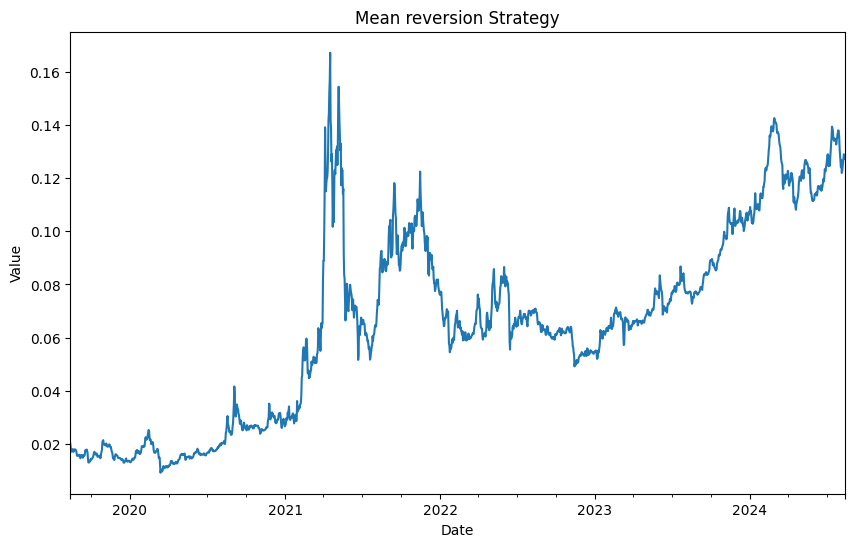

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

long_signal_dates = data[data['buy_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

short_signal_dates = data[data['sell_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Mean reversion Strategy')
plt.show()

## 2. min/max - no short sell

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from datetime import datetime, date, timedelta, timezone
from binance.enums import *
import numpy as np

quantile = 0.05
inter = "1day"

api_key = 'vBrHMZUCDxlfNiAreBj02aUrymSFMGyl1AwJNAP0O7qVlvh07Drq7qQwfQlbYGeS'
api_secret = 'SdzCkiFE5zNjkSvptRVpxQBxlUWZWYrjnRGLp5tzhzJiat79vymOH127zaKHnnCh'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
client = Client(api_key, api_secret)

today = date.today() 
today = datetime(today.year,today.month,today.day) + timedelta(days = +1) 
day7 = datetime(today.year,today.month,today.day) + timedelta(days = -1825) 
todays = today.strftime("%d-%m-%Y")
day7 = day7.strftime("%d-%m-%Y")

opt_factor = []
best_factors = []

for tick in ['SOLUSDT', 'TRXUSDT', 'XRPUSDT', 'ETHUSDT', 'BTCUSDT', 'BNBUSDT', 'ADAUSDT', 'ATOMUSDT', 'DOGEUSDT', 'LTCUSDT', 'XLMUSDT', 'NEARUSDT', 'AVAXUSDT']:

    klines = client.get_historical_klines(tick, Client.KLINE_INTERVAL_1HOUR, day7, todays)
    data = pd.DataFrame(klines, columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume', 'Ignore'])

    data.Open = data.Open.astype(float)
    data.High = data.High.astype(float)
    data.Low = data.Low.astype(float)
    data.Close = data.Close.astype(float)
    data.Volume = data.Volume.astype(float)
    data = data[['Open','High','Low','Close','Volume']]

    data['value'] = (data['Open'] + data['High'] + data['Low']) / 3
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data = data.fillna(0)

    a = list(TMRW.FINANCE.returns(data['Open'])['Open'])
    a.insert(0,0)
    data['returns'] = a

    data_day = pd.DataFrame()
    _Open = []
    _Close = []
    _High = []
    _Low = []
    _timeframe = round(len(data)/24)
    for i in range(_timeframe-1):
        _Open.append(data['Open'][i*24])
        _Close.append(data['Close'][(i+1)*24])
        _High.append(max(data['High'][i*24:(i+1)*24]))
        _Low.append(min(data['Low'][i*24:(i+1)*24]))


    data_day['Open'] = _Open
    data_day['Close'] = _Close
    data_day['High'] = _High
    data_day['Low'] = _Low

    a = list(TMRW.FINANCE.returns(data_day['Open'])['Open'])
    a.insert(0,0)
    data_day['returns'] = a

    data['buy_signal'] = False
    data['sell_signal'] = False
    
    for interval in [20,30,40,480, 10, 240, 500]:
        
        Q1 = np.zeros(len(data_day))
        Q2 = np.zeros(len(data_day))
        for i in range(interval,len(data_day)):
            Q1[i] = np.quantile(data_day['returns'][i-interval:i], 1-quantile)
            Q2[i] = np.quantile(data_day['returns'][i-interval:i], quantile)

        data_day['Q1'] = Q1
        data_day['Q2'] = Q2

        for i in range(1, len(data)):


            j = round(len(data_day)/len(data) * i)

            if j > 363:
                j = 363

            # generate long/buy signal        
            if sum(data['returns'][i-interval:i]) > data_day['Q1'][j]:
                data['buy_signal'][i] = True

            #if data['Open'][i] < data['Lower'][i]:
                #data['buy_signal'][i] = True

            if sum(data['returns'][i-interval:i]) < data_day['Q2'][j]:
                data['sell_signal'][i] = True
            
            #if data['Open'][i] > data['Upper'][i]:
                #data['sell_signal'][i] = True 
                #buy = False


        #fig, ax = plt.subplots(figsize=(10, 6))

        # Add arrows for long (buy) signals
        #signal_dates = data[data['buy_signal']].index
        #for date in signal_dates:
            #ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

        # Add arrows for short (sell) signals
        #signal_dates = data[data['sell_signal']].index
        #for date in signal_dates:
            #ax.annotate('o', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

        # Plot the time series
        #data['value'][:].plot(figsize=(10, 6))
        #plt.xlabel('Date')
        #plt.ylabel('Value')
        #plt.title('Sigma Strategy')
        #plt.show()

        val = 100
        buy = False

        for i in range(24, len(data)):
            if data['buy_signal'][i-24] == True and buy == False:
                buy = True
                vp = val / data['Close'][i] * (1 - 0.000712)

            if data['sell_signal'][i-24] == True and buy == True:
                buy = False
                val = (vp * data['Close'][i]) * (1 - 0.000712)

        opt_factor.append([inter, tick, val, interval, quantile])
        #test.append([vol, mu, )

opt_factor # 5 year data'
# somewhere between 30 and 50 days is optimal

#best_factors

[['1day', 'SOLUSDT', 1238.1651726655396, 20, 0.05],
 ['1day', 'SOLUSDT', 560.369345235649, 30, 0.05],
 ['1day', 'SOLUSDT', 418.24133836128385, 40, 0.05],
 ['1day', 'SOLUSDT', 31.140357444597722, 480, 0.05],
 ['1day', 'SOLUSDT', 4.206142775384208, 10, 0.05],
 ['1day', 'SOLUSDT', 0.8016293062632033, 240, 0.05],
 ['1day', 'SOLUSDT', 0.06157005779905709, 500, 0.05],
 ['1day', 'TRXUSDT', 384.9111233518232, 20, 0.05],
 ['1day', 'TRXUSDT', 332.23953477130016, 30, 0.05],
 ['1day', 'TRXUSDT', 396.7339749699747, 40, 0.05],
 ['1day', 'TRXUSDT', 0.02085515113217015, 480, 0.05],
 ['1day', 'TRXUSDT', 0.002281608958810318, 10, 0.05],
 ['1day', 'TRXUSDT', 3.9496607362209364e-05, 240, 0.05],
 ['1day', 'TRXUSDT', 4.934115781431467e-06, 500, 0.05],
 ['1day', 'XRPUSDT', 176.87479754437834, 20, 0.05],
 ['1day', 'XRPUSDT', 236.39054155610359, 30, 0.05],
 ['1day', 'XRPUSDT', 72.35163819724694, 40, 0.05],
 ['1day', 'XRPUSDT', 4.982104718835645e-05, 480, 0.05],
 ['1day', 'XRPUSDT', 6.055254487401883e-06, 10, 0

In [776]:
interval = 10
quantile = 0.1

data_3day = pd.DataFrame()
_Open = []
_Close = []
_High = []
_Low = []
_timeframe = round(len(data)/72)
for i in range(_timeframe-1):
    _Open.append(data['Open'][i*72])
    _Close.append(data['Close'][(i+1)*72])
    _High.append(max(data['High'][i*72:(i+1)*72]))
    _Low.append(min(data['Low'][i*72:(i+1)*72]))
    
    
data_3day['Open'] = _Open
data_3day['Close'] = _Close
data_3day['High'] = _High
data_3day['Low'] = _Low

a = list(TMRW.FINANCE.returns(data_3day['Open'])['Open'])
a.insert(0,0)
data_3day['returns'] = a

Q1 = np.zeros(len(data_3day))
Q2 = np.zeros(len(data_3day))
for i in range(interval,len(data_3day)):
    Q1[i] = np.quantile(data_3day['returns'][i-interval:i], quantile)
    Q2[i] = np.quantile(data_3day['returns'][i-interval:i], 1-quantile)

data_3day['Q1'] = Q1
data_3day['Q2'] = Q2

In [183]:
interval = 100
quantile = 0.05


data_5day = pd.DataFrame()
_Open = []
_Close = []
_High = []
_Low = []
_timeframe = round(len(data)/120)
for i in range(_timeframe-1):
    _Open.append(data['Open'][i*120])
    _Close.append(data['Close'][(i+1)*120])
    _High.append(max(data['High'][i*120:(i+1)*120]))
    _Low.append(min(data['Low'][i*120:(i+1)*120]))
    
    
data_5day['Open'] = _Open
data_5day['Close'] = _Close
data_5day['High'] = _High
data_5day['Low'] = _Low

a = list(TMRW.FINANCE.returns(data_5day['Open'])['Open'])
a.insert(0,0)
data_5day['returns'] = a

Q1 = np.zeros(len(data_5day))
Q2 = np.zeros(len(data_5day))
for i in range(interval,len(data_5day)):
    Q1[i] = np.quantile(data_5day['returns'][i-interval:i], quantile)
    Q2[i] = np.quantile(data_5day['returns'][i-interval:i], 1-quantile)

data_5day['Q1'] = Q1
data_5day['Q2'] = Q2

In [21]:
var = 0
for i in range(len(opt_factor)):
    if opt_factor[i][1] > var:
        best_factors = opt_factor[i]
        var = opt_factor[i][1]
        

[['1day', 'SOLUSDT', 5324.876483988045, 20, 0.05],
 ['1day', 'SOLUSDT', 1969.6259013526633, 30, 0.05],
 ['1day', 'SOLUSDT', 1242.0229126850609, 40, 0.05],
 ['1day', 'SOLUSDT', 10.876721288635089, 480, 0.05],
 ['1day', 'SOLUSDT', 3.548739983994136, 10, 0.05],
 ['1day', 'SOLUSDT', 0.28376432665576395, 240, 0.05],
 ['1day', 'SOLUSDT', 0.016982551310690285, 500, 0.05],
 ['1day', 'TRXUSDT', 120.4393022202943, 20, 0.05],
 ['1day', 'TRXUSDT', 91.96014832993325, 30, 0.05],
 ['1day', 'TRXUSDT', 52.1858733061008, 40, 0.05],
 ['1day', 'TRXUSDT', 0.0190167326302821, 480, 0.05],
 ['1day', 'TRXUSDT', 0.004638509505572783, 10, 0.05],
 ['1day', 'TRXUSDT', 7.843915760484566e-05, 240, 0.05],
 ['1day', 'TRXUSDT', 7.2795450851357475e-06, 500, 0.05],
 ['1day', 'XRPUSDT', 429.58098943989535, 20, 0.05],
 ['1day', 'XRPUSDT', 188.75720739798177, 30, 0.05],
 ['1day', 'XRPUSDT', 47.04859422536558, 40, 0.05],
 ['1day', 'XRPUSDT', 0.0001745596072770732, 480, 0.05],
 ['1day', 'XRPUSDT', 1.4385598175119645e-05, 10, 

In [ ]:
data['value'] = (data['Open'] + data['Close']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a

data['RSI'] = TMRW.FINANCE.RSI(data['value'],6)


data['buy_signal'] = False
data['sell_signal'] = False

for i in range(4, len(data)):
    
    # generate long/buy signal  
    if np.mean(data['returns'][i-24:i]) > np.mean(data['returns'][i-48:i-24]) and np.mean(data['returns'][i-48:i-24]) < np.mean(data['returns'][i-72:i-48]) and np.mean(data['value'][i-72:i-48]) > np.mean(data['value'][i-24:i]):
        if np.mean(data['returns'][i-2:i]) > np.mean(data['returns'][i-12:i-5]) and np.mean(data['returns'][i-12:i-5]) < np.mean(data['returns'][i-24:i-12]) and np.mean(data['value'][i-24:i-12]) > np.mean(data['value'][i-4:i]):
            #if np.mean(data['returns'][i-96:i-72]) < np.mean(data['returns'][i-72:i-48]):
                data['buy_signal'][i] = True
    #elif data['sell_signal'][i-4] == True:
        #data['buy_signal'][i] = True

        
    # generate short/sell signal
    if np.mean(data['returns'][i-24:i]) < np.mean(data['returns'][i-48:i-24]) and np.mean(data['returns'][i-48:i-24]) > np.mean(data['returns'][i-72:i-48]):
        if np.mean(data['returns'][i-2:i]) < np.mean(data['returns'][i-12:i-5]) and np.mean(data['returns'][i-12:i-5]) > np.mean(data['returns'][i-24:i-12]):
            #if np.mean(data['returns'][i-96:i-72]) > np.mean(data['returns'][i-72:i-48]):
            data['sell_signal'][i] = True
        
    #if data['High'][i-1] > data['High'][i-3] and data['High'][i-2] > data['High'][i-4] and data['value'][i] > data['High'][i-2]:
        #data['sell_signal'][i] = True

-14.21463554528762

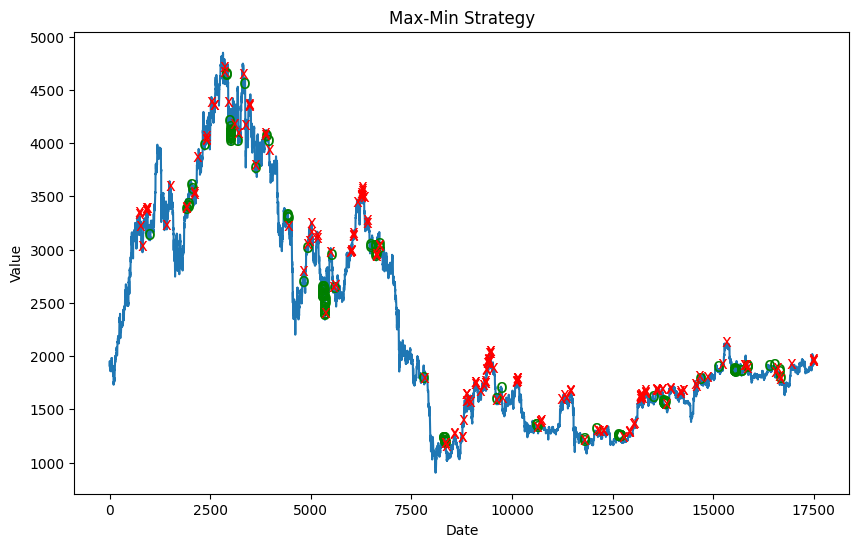

In [234]:
#data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a


data['RSI'] = TMRW.FINANCE.RSI(data['value'],144)
data['buy_signal'] = False
data['sell_signal'] = False

k = 0
j = 0

for i in range(720,len(data)):

    # generate long/buy signal

    if np.mean(data['returns'][i-720:i]) < 0 and np.mean(data['returns'][i-480:i]) < 0.01 and np.mean(data['returns'][i-240:i]) < 0:
        
        if buy == True:
            data['sell_signal'][i] = True
            buy = False
            
        next
        
        
    elif np.std(data['returns'][i-200:i]) < -0.06 or np.std(data['returns'][i-200:i]) > 0.06:
        
        next
    
    
    else:

        if data['Open'][i] < 1.001 * min(data['value'][i-480:i-24]) and np.mean(data['returns'][i-480:i-24]) > 0:
            #if data['Open'][i] 
            data['buy_signal'][i] = True
            k = i
            buy = True

        elif data['Open'][i] < 1.0001 * min(data['value'][i-480:i-24]) and np.mean(data['returns'][i-240:i-24]) > -0.01:
            data['buy_signal'][i] = True
            k = i
            buy = True

        elif data['Open'][i] < 1.001 * min(data['value'][i-36:i-12]) and np.mean(data['returns'][i-24:i-1]) > -0.01 and np.mean(data['returns'][i-24:i-4]) > np.mean(data['returns'][i-480:i-48]) and data['Open'][i] > 0.92 * np.mean(data['Open'][i-48:i-6]):
            if np.mean(data['returns'][i-24:i]) < 0.01 and np.mean(data['returns'][i-12:i-4]) < 0 and np.mean(data['returns'][i-4:i]) > -0.01:
                data['buy_signal'][i] = True
                k = i
                buy = True

        # generate short/sell signal

        if data['Open'][i] > 1.3 * data['Open'][k] and data['Open'][i] > 0.9999 * max(data['value'][i-480:i-24]) and np.mean(data['returns'][i-24:i-4]) < np.mean(data['returns'][i-480:i-48]):
            data['sell_signal'][i] = True
            buy = False

        if data['Open'][i] > 0.9 * max(data['value'][i-240:i-24]):
            if np.mean(data['returns'][i-30:i-10]) > 0.001 and np.mean(data['returns'][i-24:i-8]) > -0.0005 and np.mean(data['returns'][i-24:i-8]) < 0.0005 and np.mean(data['returns'][i-12:i]) < -0.0005:
                data['sell_signal'][i] = True
                buy = False
        
    

        
fig, ax = plt.subplots(figsize=(10, 6))

long_signal_dates = data[data['buy_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

short_signal_dates = data[data['sell_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Max-Min Strategy')

val = 100
buy = False

for i in range(len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        vp = val / data['Close'][i] * (1 - 0.000712)
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = (vp * data['Close'][i]) * (1 - 0.000712)

        
val - 100

## 3. Trend following - mean return

In [242]:
today = date.today() 
time = three #m1, m3, m6, one, three, five
Symbol = "MSFT"

44.012120589980384

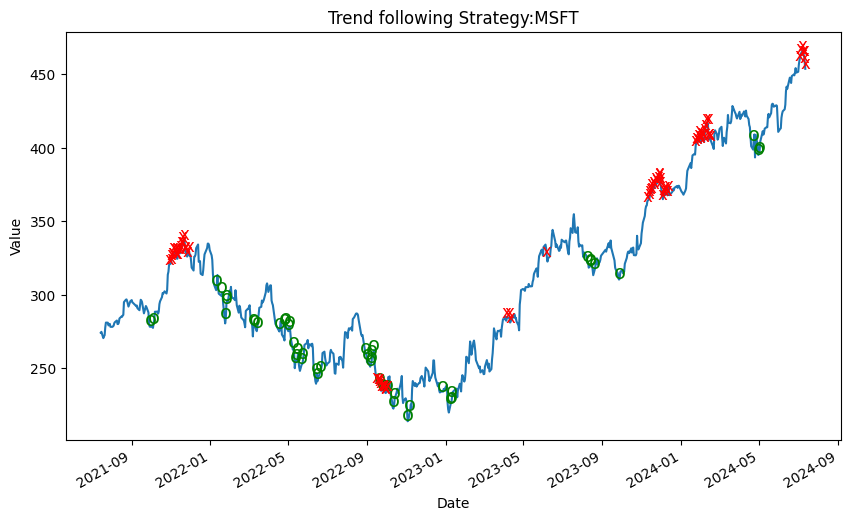

In [243]:
import warnings
warnings.filterwarnings("ignore")

data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a

data['mean_return'] = data['returns'].rolling(window=30).mean().values.flatten()
data['autocorr_30'] = data['value'].rolling(window=30).apply(lambda x: x.autocorr())
data['buy_signal'] = False
data['sell_signal'] = False

for i in range(3,len(data)):
    
    # generate long/buy signal

    if data['mean_return'][i] < np.mean(data['returns']) and data['value'][i] < 0.97*np.mean(data['value'][i-30:i]) and data['value'][i] > data['value'][i-1]:
        data['buy_signal'][i] = True 
        
    #if data['mean_return'][i-3] > 0 and data['mean_return'][i-2] > 0 and data['mean_return'][i-1] > 0 and np.mean(data['returns'][i-2:i]) < 0 :
    if data['autocorr_30'][i] > 0.96 or data['value'][i] > 1.2*np.mean(data['value'][i-30:i]) :
        data['sell_signal'][i] = True    
        

        
fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
signal_dates = data[data['buy_signal']].index
for date in signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
signal_dates = data[data['sell_signal']].index
for date in signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trend following Strategy:' + Symbol)

val = 100
buy = False

for i in range(len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        vp = val / data['Close'][i] * (1 - 0.000712)
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = (vp * data['Close'][i]) * (1 - 0.000712)

        
val - 100


## 4. trend following - xxx

In [319]:
time = one #m1, m3, m6, one, three, five
Symbol = "MSFT"

In [40]:
((val-100)/100)/(np.std(data['value'])/np.mean(data['value']))

0.2915113799502953

13.587253546193509

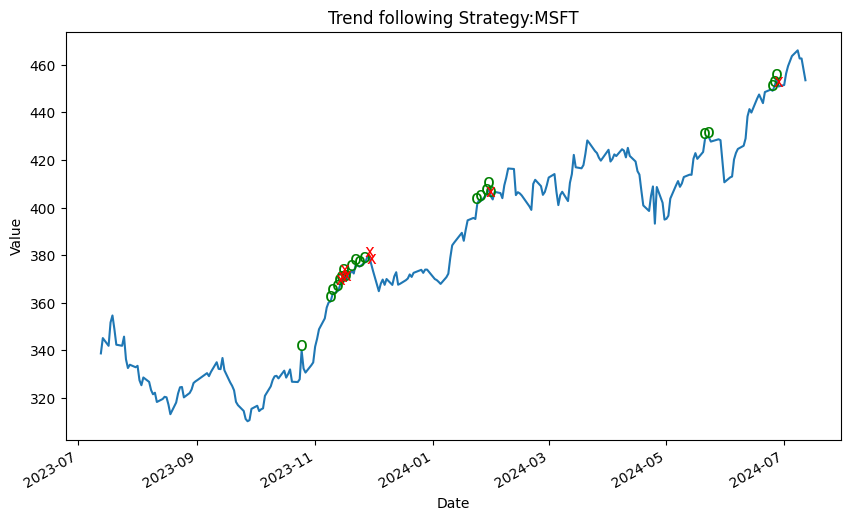

In [199]:
import warnings
warnings.filterwarnings("ignore")

data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a

pos_neg = []
for i in range(len(data)):
    if data['returns'][i] >= 0:
        pos_neg.append(1)
    elif data['returns'][i] < 0:
        pos_neg.append(-1)
        
data['pos_neg'] = pos_neg

data['mean_return'] = data['returns'].rolling(window=15).mean().values.flatten()
data['autocorr_30'] = data['value'].rolling(window=30).apply(lambda x: x.autocorr())
data['RSI'] = TMRW.FINANCE.RSI(data['value'],5)
data['buy_signal'] = False
data['sell_signal'] = False
data['short_signal'] = False
data['long_signal'] = False
s = False

for i in range(3,len(data)):
    
    # generate long/buy signal

    if data['mean_return'][i] > 0.005 and data['returns'][i-1] < 0.01 and data['returns'][i-2] < 0.02:
        data['buy_signal'][i] = True 
        
    if data['buy_signal'][i-3] == True and data['returns'][i-1] > 0 and data['returns'][i-2] > 0:
        data['sell_signal'][i] = True 
    
    
    
    # generate short/sell signal
    if data['mean_return'][i] < -0.01 and s == False:
        data['short_signal'][i] = True
        s = True
    
    if data['returns'][i-1] > 0 and data['returns'][i-2] > 0 and s == True:
        data['long_signal'][i] = True
        s = False
    
        

        
fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
signal_dates = data[data['buy_signal']].index
for date in signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
signal_dates = data[data['sell_signal']].index
for date in signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')
    

signal_dates = data[data['short_signal']].index
for date in signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')
    
signal_dates = data[data['long_signal']].index
for date in signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='green', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trend following Strategy:' + Symbol)

val = 100
buy = False
buy2 = False

for i in range(len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        buy_price = data['Open'][i] - 0.005 * data['Open'][i]
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = val * (1 - 0.005+(data['Close'][i] - buy_price)/buy_price)
    
    if data['short_signal'][i] == True and buy2 == False:
        buy2 = True
        buy2_price = data['Open'][i] - 0.005 * data['Open'][i]
    
    if (data['long_signal'][i] == True or data['buy_signal'][i] == True) and buy2 == True:
        buy2 = False
        val = val * (1 - 0.005 +(buy2_price-data['Close'][i])/buy2_price)
    
        

val-100

## 5. Trend following - pos/neg counter

In [396]:
time = one #m1, m3, m6, one, three, five
Symbol = "ETH-USD"

In [389]:
((val-100)/100)/(np.std(data['value'])/np.mean(data['value']))

2.90335223638314

75.6351854293832

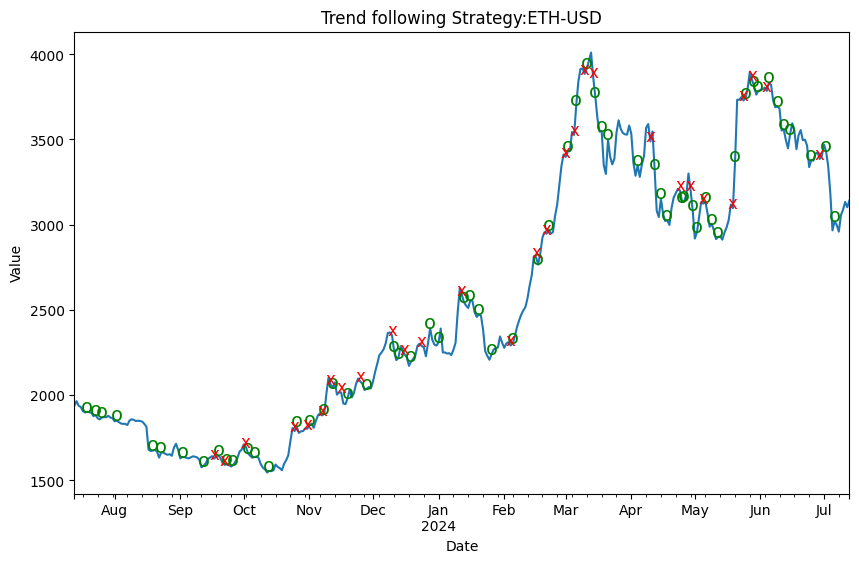

In [397]:
import warnings
warnings.filterwarnings("ignore")

#data = b.copy()
#data.Open = data.Open.astype(float)
#data.High = data.High.astype(float)
#data.Low = data.Low.astype(float)
#data.Close = data.Close.astype(float)
#data.Volume = data.Volume.astype(float)
#data = data[['Open','High','Low','Close','Volume']]

data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a

pos_neg = []
for i in range(len(data)):
    if data['returns'][i] >= 0:
        pos_neg.append(1)
    elif data['returns'][i] < 0:
        pos_neg.append(-1)
        
data['pos_neg'] = pos_neg

data['mean_return'] = data['returns'].rolling(window=15).mean().values.flatten()
data['autocorr_30'] = data['value'].rolling(window=30).apply(lambda x: x.autocorr())
data['RSI'] = TMRW.FINANCE.RSI(data['value'],5)
data['buy_signal'] = False
data['sell_signal'] = False
data['short_signal'] = False
data['long_signal'] = False

for i in range(1,len(data)):
    
    # generate long/buy signal

    if np.mean(data['pos_neg'][i-2:i]) < 0 and data['value'][i] > data['value'][i-1] and data['value'][i] < np.mean(data['value'][i-5:i-2]):
        data['buy_signal'][i] = True
        k = i
        buy = True
        
    elif buy == False and np.mean(data['pos_neg'][i-10:i]) > 0:
        data['buy_signal'][i] = True
        k = i
        buy = True
        
    if np.mean(data['pos_neg'][i-10:i]) > 0 and data['value'][i] < data['value'][i-1] and i-k > 2:
        data['sell_signal'][i] = True
        buy = False
    
    
    
    # generate short/sell signal
    #if data['pos_neg'][i] < np.mean(data['pos_neg'][i-30:i]):
        #data['short_signal'][i] = True
    
    #if data['short_signal'][i-1] == True and data['returns'][i] > 0:
        #data['long_signal'][i] = True
    
        

        
fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
signal_dates = data[data['buy_signal']].index
for date in signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
signal_dates = data[data['sell_signal']].index
for date in signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')
    

#signal_dates = data[data['short_signal']].index
#for date in signal_dates:
    #ax.annotate('o', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')
    
#signal_dates = data[data['long_signal']].index
#for date in signal_dates:
    #ax.annotate('x', xy=(date, data.loc[date, 'value']), color='green', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trend following Strategy:' + Symbol)

val = 100
buy = False
#buy2 = False

for i in range(len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        buy_price = data['Open'][i] - 0.005 * data['Open'][i]
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = val * (1 - 0.005 + (data['Close'][i] - buy_price)/buy_price)
    
    
    #if data['short_signal'][i] == True and buy2 == False:
        #buy2 = True
        #buy2_price = data['Open'][i] - 0.005 * data['Open'][i]
    
    #if data['long_signal'][i] == True and buy2 == True:
        #buy2 = False
        #val = val * (1 - 0.005 + (buy2_price-data['Close'][i])/buy2_price)
    
        

val-100

## 5. 2sigma

In [1]:
def bollinger_bands(data, length):
    mean_lst = np.zeros(len(data))
    std_lst = np.zeros(len(data))
    for i in range(0, length):
        mean_lst[i] = data[i]
        std_lst[i] = 0.05 * data[i]
    
    for i in range(length,len(data)):
        mean_lst[i] = np.mean(data[i-length:i])
        std_lst[i] = np.std(data[i-length:i])
        
    up = mean_lst + 2.5 * std_lst
    down = mean_lst - 2.5 * std_lst
    
    boll = pd.DataFrame()
    boll['Upper'] = up
    boll['Lower'] = down
    return(boll)

In [245]:
time = three #m1, m3, m6, one, three, five
Symbol = "MSFT"

In [190]:
((val-100)/100)/(np.std(data['value'])/np.mean(data['value']))

0.6676868568244915

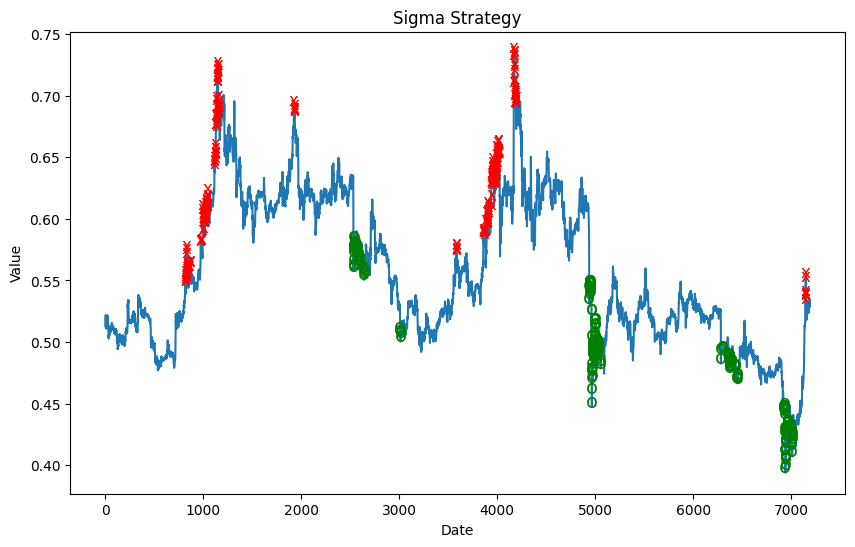

4.233258165173723

In [7]:
import warnings
warnings.filterwarnings("ignore")

#data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a

data['Lower'] = bollinger_bands(data['value'],720)['Lower']
data['Upper'] = bollinger_bands(data['value'],720)['Upper']

data['buy_signal'] = False
data['sell_signal'] = False
buy = False

for i in range(720, len(data)):
    
    # generate long/buy signal        
    if data['value'][i] < data['Lower'][i]:
        data['buy_signal'][i] = True
    
    if data['value'][i] > data['Upper'][i]:
        data['sell_signal'][i] = True 
        buy = False
        
        
fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
signal_dates = data[data['buy_signal']].index
for date in signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
signal_dates = data[data['sell_signal']].index
for date in signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sigma Strategy')
plt.show()

val = 100
buy = False

for i in range(len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        vp = val / data['Close'][i] * (1 - 0.000712)
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = (vp * data['Close'][i]) * (1 - 0.000712)

val - 100

# more signals

In [ ]:
#Autocorrelation test - too many problems

import warnings
warnings.filterwarnings("ignore")


data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)
a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a
data['autocorr_30'] = data['value'].rolling(window=15).apply(lambda x: x.autocorr())
data['RSI'] = TMRW.FINANCE.RSI(data['value'],5)
data['buy_signal'] = False
data['sell_signal'] = False
data['short_signal'] = False
data['long_signal'] = False

for i in range(len(data)):
    
    if i > 100 and data['returns'][i] > 0.7 * max(data['returns'][i-100:i]):
        next
        
    elif i > 100 and data['value'][i] > 0.7 * max(data['value'][i-100:i]):
        next
        
    else:

        # generate long/buy signal

        if data['autocorr_30'][i] > 0.90 and np.mean(data['returns'][i-15:i]) < 0:
            data['buy_signal'][i] = True 

        if (data['autocorr_30'][i] < 0.76 and np.mean(data['returns'][i-15:i]) < 0):
            data['sell_signal'][i] = True
            
        elif (i> 60 and data['value'][i-1] > 0.9*max(data['value'][i-60:i])):
            data['sell_signal'][i] = True
    
    
        

        
fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
signal_dates = data[data['buy_signal']].index
for date in signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
signal_dates = data[data['sell_signal']].index
for date in signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')


# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Autocorrelation Strategy:' + Symbol)

val = 100

buy_count = 0
buy = False
buy2 = False

for i in range(len(data)):
    
    if data['buy_signal'][i] == True:
        buy_count = buy_count + 1
    
    if buy_count > 3 and buy == False:
        buy = True
        buy_price = data['Open'][i]    
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = val * (1+(data['Close'][i] - buy_price)/buy_price)
    
        

val

In [ ]:
import warnings
warnings.filterwarnings("ignore")


data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)
a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a
data['autocorr_30'] = data['value'].rolling(window=30).apply(lambda x: x.autocorr())

data['buy_signal'] = False
data['sell_signal'] = False
data['short_signal'] = False
data['long_signal'] = False

for i in range(len(data)):
    
    # generate long/buy signal

    if data['autocorr_30'][i] < 0.78 and data['returns'][i-1] > 0:
        data['buy_signal'][i] = True 
        
    if data['autocorr_30'][i] > 0.95 and data['returns'][i] < -0.02:
        data['sell_signal'][i] = True 
    
    
    
    # generate short/sell signal
    if data['sell_signal'][i-1] == True:
        data['short_signal'][i] = True
    
    if data['buy_signal'][i-1] == True  :
        data['long_signal'][i] = True
    
        

        
fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
signal_dates = data[data['buy_signal']].index
for date in signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
signal_dates = data[data['sell_signal']].index
for date in signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')
    

signal_dates = data[data['short_signal']].index
for date in signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')
    
signal_dates = data[data['long_signal']].index
for date in signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='green', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trend following Strategy:' + Symbol)

val = 100
buy = False
buy2 = False

for i in range(len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        buy_price = data['Open'][i]    
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = val * (1+(data['Close'][i] - buy_price)/buy_price)
    
    
    if data['short_signal'][i] == True and buy2 == False:
        buy2 = True
        buy2_price = data['Open'][i]
    
    if data['long_signal'][i] == True and buy2 == True:
        buy2 = False
        val = val * (1+(buy2_price-data['Close'][i])/buy2_price)
    
        

val


import warnings
warnings.filterwarnings("ignore")

df = pd.DataFrame()
threshold = 0.1
n = 100
for i in range(len(lste[0:n])):
    df[lste[i]] = TMRW.DATA.data(lste[i],m6,today)['High']
    #alph = np.zeros(152)
    #for j in range(len(alpha)):
        #alph[j] = np.mean(list(alpha.iloc[j,0:4]))
    
    #df[lste[i]] = TMRW.DATA.data(lste[i],m6,today)

df.replace([np.inf, -np.inf], 0, inplace=True)
df = df.fillna(0)
lst = []
for i in range(len(df.columns)):
    if np.mean(df.iloc[:,i]) == 0:
        lst.append(i)

df = df.drop(df.columns[lst], axis=1)

values = pd.DataFrame(df['BTC-USD'].values)
data = pd.DataFrame({'value': values[0]})
a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a
data['mean_return'] = data['returns'].rolling(window=15).mean().values.flatten()
data['autocorr_30'] = data['value'].rolling(window=30).apply(lambda x: x.autocorr())
data['MA15'] = TMRW.FINANCE.twa(data['value'], 15)[14]
data['MA15'][0] = 0
data['MA60'] = TMRW.FINANCE.twa(data['value'], 30)[29]
data['MA60'][0] = 0
data['Lower'] = TMRW.FINANCE.bollinger_bands(data['value'], 15)['Lower']
data['Upper'] = TMRW.FINANCE.bollinger_bands(data['value'], 15)['Upper']
data['RSI'] = TMRW.FINANCE.RSI(data['value'],5)
data['long_signal'] = False
data['short_signal'] = False

for i in range(len(data)):
    
    # generate long/buy signal
    if (data['MA15'][i] < data['MA60'][i]) and (data['MA15'][i] > data['value'][i]) and (data['value'][i] < data['Lower'][i]):# and (data['RSI'][i] >25):
        data['long_signal'][i] = True
    
    elif data['mean_return'][i] > 0.005 and (data['value'][i] < 1.05*data['MA15'][i]) and (data['RSI'][i] < 60):
        data['long_signal'][i] = True 
    
    
    
    # generate short/sell signal
    if data['MA15'][i] > data['MA60'][i] and data['MA15'][i] < data['value'][i] and data['value'][i] > data['Upper'][i]:
        data['short_signal'][i] = True
    
    elif data['mean_return'][i] < -0.005 and (data['value'][i] < data['MA15'][i]) and (data['value'][i] < data['MA60'][i]) and (data['RSI'][i] < 40) and (data['RSI'][i] > 20):
        data['short_signal'][i] = True
        
fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
long_signal_dates = data[data['long_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = data[data['short_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')



import warnings
warnings.filterwarnings("ignore")

df = pd.DataFrame()
threshold = 0.1
n = 100
for i in range(len(lste[0:n])):
    df[lste[i]] = TMRW.DATA.data(lste[i],m6,today)['Low']
    #alph = np.zeros(152)
    #for j in range(len(alpha)):
        #alph[j] = np.mean(list(alpha.iloc[j,0:4]))
    
    #df[lste[i]] = TMRW.DATA.data(lste[i],m6,today)

df.replace([np.inf, -np.inf], 0, inplace=True)
df = df.fillna(0)
lst = []
for i in range(len(df.columns)):
    if np.mean(df.iloc[:,i]) == 0:
        lst.append(i)

df = df.drop(df.columns[lst], axis=1)

values = pd.DataFrame(df['BTC-USD'].values)
data = pd.DataFrame({'value': values[0]})
a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a
data['mean_return'] = data['returns'].rolling(window=15).mean().values.flatten()
data['autocorr_30'] = data['value'].rolling(window=30).apply(lambda x: x.autocorr())
data['MA15'] = TMRW.FINANCE.twa(data['value'], 15)[14]
data['MA15'][0] = 0
data['MA60'] = TMRW.FINANCE.twa(data['value'], 30)[29]
data['MA60'][0] = 0
data['Lower'] = TMRW.FINANCE.bollinger_bands(data['value'], 15)['Lower']
data['Upper'] = TMRW.FINANCE.bollinger_bands(data['value'], 15)['Upper']
data['RSI'] = TMRW.FINANCE.RSI(data['value'],5)
data['long_signal'] = False
data['short_signal'] = False

for i in range(len(data)):
    
    # generate long/buy signal
    if (data['MA15'][i] < data['MA60'][i]) and (data['MA15'][i] > data['value'][i]) and (data['value'][i] < data['Lower'][i]):# and (data['RSI'][i] >25):
        data['long_signal'][i] = True
    
    elif data['mean_return'][i] > 0.005 and (data['value'][i] < 1.05*data['MA15'][i]) and (data['RSI'][i] < 60):
        data['long_signal'][i] = True 
    
    
    
    # generate short/sell signal
    if data['MA15'][i] > data['MA60'][i] and data['MA15'][i] < data['value'][i] and data['value'][i] > data['Upper'][i]:
        data['short_signal'][i] = True
    
    elif data['mean_return'][i] < -0.005 and (data['value'][i] < data['MA15'][i]) and (data['value'][i] < data['MA60'][i]) and (data['RSI'][i] < 40) and (data['RSI'][i] > 20):
        data['short_signal'][i] = True
        
fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
long_signal_dates = data[data['long_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = data[data['short_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Visualise autocorrelation using the plot_acf function
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(data['value'], lags=30, ax=ax)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')

plt.show()

# Plot the PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(data['value'], lags=30, ax=ax)

plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')

plt.show()

In [6]:
# correlation og cointegration liste
m1_c = pd.DataFrame(corr_coint_list(lste, m1, today))
m3_c = pd.DataFrame(corr_coint_list(lste, m3, today))
m6_c = pd.DataFrame(corr_coint_list(lste, m6, today))

# stationarity, randomwalk, mean reversion check 1, mean reversion check 2, Linear trend, Linear Trend, Exponential trend?, auto-correlation?
m1_s = stat_test(m1, today, lste, "prices", 15)
m3_s = stat_test(m3, today, lste, "prices", 15)
m6_s = stat_test(m6, today, lste, "prices", 15)



# linear pairing mellem a og b currency
# Are there resistance levels?
# trend detection with returns mean
# Trend detection with autocorrelation loss?






with pd.ExcelWriter("E:/Investering/stats.xlsx") as writer:
    for i in range(6):
        if i == 0:
            m1_c.to_excel(writer, sheet_name="1m corr coint")
        elif i == 1:
            m1_s.to_excel(writer, sheet_name="1m stats")
        elif i == 2:
            m3_c.to_excel(writer, sheet_name="3m corr coint")
        elif i == 3:
            m3_s.to_excel(writer, sheet_name="3m stats")
        elif i == 4:
            m6_c.to_excel(writer, sheet_name="6m corr coint")
        elif i == 5:
            m6_s.to_excel(writer, sheet_name="6m stats")
            
            
# round(a.half_life_v2(x)/PERIOD_PER_DAY)

# detect overall markov chain

# detect overall mean reversion times

# detect overall mean reversion sizes

C:\Users\Markb\AppData\Local\Temp\ipykernel_8572\662737855.py:227: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']
C:\Users\Markb\AppData\Local\Temp\ipykernel_8572\662737855.py:227: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']
C:\Users\Markb\AppData\Local\Temp\ipykernel_8572\662737855.py:227: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

NameError: name 'adfuller' is not defined

### Statistical Tests?

In [ ]:


import math
import numpy as np
import pandas as pd
from scipy.stats import norm, mstats
import TMRW

def mk_test(ts, mode = 'simple', window = 50, alpha = 0.00001):
    """
    Mann-Kendall test for trend
    Detects linear trends (in pair with cox_stuart)
    Optimal window = 50

    Input:
        x:   a vector of data
        alpha: significance level (0.001 default)
        window: last n values, for finding trend
        mode: 
            - 'full' - if you need to know trend direction; 
            - 'simple' - if just trend existance.

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics 

    """
    x = ts[-window:]
    n = len(x)

    # calculate S 
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])
    #s = [-1 if x[j] < x[k] else 1 for j in xrange(k+1,n) for k in xrange(n-1)]

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)
    # calculate the var(s)
    n = float(n)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
        #print (var_s)
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test

    h = abs(z) > norm.ppf(1-alpha/2) 

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    if mode == 'full':
        return trend, h, p, z
    else:
        return h, abs(z)


def cox_stuart(timeseries, window = 50, alpha = 0.0001, debug = False):
    """
    Cox-Stuart criterion
    H0: trend exists
    H1: otherwise

    Detects linear trends
    Optimal window = 50
    """
    n = window
    idx = np.arange(1,n+1)
    X = pandas.Series(timeseries[-n:], index=idx)
    
    S1 = [(n-2*i) if X[i] <= X[n-i+1] else 0 for i in range(1,n//2)]
    n = float(n)
    S1_ = (sum(S1) - n**2 / 8) / math.sqrt(n*(n**2-1)/24)
    u = norm.ppf(1-alpha/2)
    if debug:
        print ('|S1*|:', abs(S1_))
        print ("u:",u)
    
    return abs(S1_) > u, abs(S1_) #H0 accept

def abbe_criterion(timeseries, window = 40, alpha = .00001, debug = False):

    """
    Abbe-Linnik criterion
    Detects exponential trend (in pair with autocorrelation)
    If window >50 => too much True
    """
    if len(timeseries) < window:
        return False
    series = pandas.Series(timeseries)
    a = series[-window:]
    mean = a.mean()
    

    X = zip(a[:-1],a[1:])
    s1 = sum([math.pow((x[0]-x[1]),2) for x in X])
    s2 = sum([pow((x-mean),2) for x in a])
    q = 0.5 * s1 / s2
    q_a = 0.6814
    n = len(a)
    Q = -(1-q)*math.sqrt((2*n+1)/(2-pow((1-q),2)))
    u = norm.ppf(alpha) #kobzar page 26
    if debug:
        print ('mean:', mean)
        print ('q:', q)
        print ('Q*:', Q)
        print ('U_alpha-1:', u)
    return Q < u, abs(Q)


def autocorrelation(timeseries, window = 50, alpha = .00001, debug = False):
    """
    Detects exponential trend

    """
    n = window
    idx = np.arange(1,n+1)
    series = pandas.Series(list(timeseries[-n:]), index=idx)

    X = zip(series[:-1],series[1:])
    sqr_sum = pow(sum(series),2)
    n_f = float(n)
    r = (n_f * sum([x[0]*x[1] for x in X]) - sqr_sum + n_f*series[1]*series[n]) / \
        (n_f * sum([x**2 for x in series]) - sqr_sum)
    
    r_ = abs(r + 1./(n_f-1.)) / math.sqrt(n_f*(n_f-3)/(n_f+1)/pow((n_f-1),2))
    u = norm.ppf(1-alpha/2)
    
    return abs(r_) > u, abs(r_)
















# for hver invertering af MA5 og MA21. Hvor lang tid går der så indtil vi rammer samme pris som inverteringsprisen?
def mr_times(data):

    lstma5_times = []

    for i in range(1, len(data)):

        if (data.iloc[i,17] > data.iloc[i,3] and data.iloc[i-1,17] <= data.iloc[i-1,3]):
            lstma5_times.append(i)
        elif (data.iloc[i,17] < data.iloc[i,3] and data.iloc[i-1,17] >= data.iloc[i-1,3]):
            lstma5_times.append(i)

    lst1 = []
    for i in range(1, len(lstma5_times)):
        lst1.append(lstma5_times[i] - lstma5_times[i-1])


    lstma21_times = []

    for i in range(1, len(data)):

        if (data.iloc[i,27] > data.iloc[i,3] and data.iloc[i-1,27] < data.iloc[i-1,3]):
            lstma21_times.append(i)
        elif (data.iloc[i,27] < data.iloc[i,3] and data.iloc[i-1,27] > data.iloc[i-1,3]):
            lstma21_times.append(i)

    lst2 = []
    for i in range(1, len(lstma21_times)):
        lst2.append(lstma21_times[i] - lstma21_times[i-1])
        
    return([lst1,lst2])

def ed(data, bins = 10):

    bine = np.linspace(min(data), max(data), bins)
    counts = []

    for i in range(0,len(bine)):

        bine[i] = round(bine[i],3)
        count = 0

        for j in range(len(data)):

            if data.iloc[j] >= bine[i-1] and data.iloc[j] < bine[i]:

                count = count + 1

        counts.append(count/len(data))

    counts_df = pd.DataFrame(counts, index = bine)
    return(counts_df)


























def corr_coint(data):
    correlations = data.corr()


    co_int = pd.DataFrame("", columns = data.columns, index = data.columns)

    for i in range(len(data.columns)):

        for j in range(len(data.columns)):

            if a.perform_coint_test(data.iloc[:,i], data.iloc[:,j], False)[1] == False:
                co_int.iloc[i,j] = "False"
            elif a.perform_coint_test(data.iloc[:,i], data.iloc[:,j], False)[1] == True:
                co_int.iloc[i,j] = "True"

    couplings = []
    for i in range(len(co_int.columns)):
        for j in range(len(co_int)):

            if i!=j:
                if co_int.iloc[j,i] == "True" and correlations.iloc[j,i] > 0.8:
                    couplings.append([co_int.columns[i], co_int.index[j]])
    return(couplings)

def corr_coint_list(lste, fra, til):
    prices = pd.DataFrame()

    for i in range(len(lste)):
        prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']

    prices = prices.fillna(0)

    lst = []
    for i in range(len(prices.columns)):
        if np.mean(prices.iloc[:,i]) == 0:
            lst.append(i)

    prices = prices.drop(prices.columns[lst], axis=1)

    returns = prices.pct_change()#.dropna()
    returns = returns.iloc[1:len(returns),:]
    returns.replace([np.inf, -np.inf], 0, inplace=True)
    returns = returns.fillna(0)

    prices_list = corr_coint(prices)
    returns_list = corr_coint(returns)

    lst = []
    for i in returns_list:
        for j in prices_list:
            if i == j:
                lst.append(i)
    return(lst)

def stat_test(fra, til, lste, typ, win):
    
    prices = pd.DataFrame()

    for i in range(len(lste)):
        prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']

    prices = prices.fillna(0)

    lst = []
    for i in range(len(prices.columns)):
        if np.mean(prices.iloc[:,i]) == 0:
            lst.append(i)

    prices = prices.drop(prices.columns[lst], axis=1)

    returns = prices.pct_change()#.dropna()
    returns = returns.iloc[1:len(returns),:]
    returns.replace([np.inf, -np.inf], 0, inplace=True)
    returns = returns.fillna(0)

    if typ == "prices":
        data = prices
    elif typ == "returns":
        data = returns
    
    df = []
    for i in range(len(data.columns)):
        if a.perform_adf_test(data.iloc[:,i])[2] == True:
            b = "Stationary"
        else:
            b = "Non-stationary"

        if a.perform_variance_ratio_test(data.iloc[:,i])[1] == True:
            c = "Random walk"
        else:
            c = "Not Random walk"

        if a.perform_hurst_exp_test(data.iloc[:,i])[0] < 0.25:
            d = "Mean reverting"
        elif a.perform_hurst_exp_test(data.iloc[:,i])[0] > 0.75:
            d = "Trending"
        else:
            d = "None"

        adf = adfuller(data.iloc[:,i], 1)

        if adf[1] < 0.2 and adf[0] > (adf[4]['10%'] - adf[4]['1%'])/adf[4]['1%'] * 20: 
            d_ = "Mean reverting"

        elif adf[1] < 0.1 and adf[0] > adf[4]['10%']:
            d_ = "not mean reverting"

        elif (adf[0] > dict(adf[4])['1%']) and (adf[0] > dict(adf[4])['5%']) and (adf[0] > dict(adf[4])['10%']):
            d_ = "not mean reverting"

        else:
            d_ = "Mean reverting"

        if mk_test(data.iloc[:,i], mode = 'simple', window = win, alpha = 0.05)[0] == False:
            e = "Non-Trending"
        elif mk_test(data.iloc[:,i], mode = 'simple', window = win, alpha = 0.05)[0] == True:
            e = "Trending"

        if cox_stuart(data.iloc[:,i], window = win, alpha = 0.00005)[0] == False:
            f = "Non-Trending"
        elif cox_stuart(data.iloc[:,i], window = win, alpha = 0.00005)[0] == True:
            f = "Trending"

        if abbe_criterion(data.iloc[:,i], window = win, alpha = 0.00005)[0] == False:
            g = "Non-Trending"
        elif abbe_criterion(data.iloc[:,i], window = win, alpha = 0.00005)[0] == True:
            g = "Trending"

        if autocorrelation(data.iloc[:,i], window = win, alpha = 0.0001)[0] == False:
            h = "Non-Trending"
        elif autocorrelation(data.iloc[:,i], window = win, alpha = 0.0001)[0] == True:
            h = "Trending"



        df.append([prices.columns[i],b,c,d,d_,e,f,g,h])
    df = pd.DataFrame(df, columns = ['Symbol', 'Stationarity', 'Randomwalk(yes/no)', 'Hurst Exponent', 'ADfuller test', 'MK test', 'Cox Stuart', 'Abbe Criterion', 'Autocorrelation'])
    return(df)





# correlation og cointegration liste
m1_c = pd.DataFrame(corr_coint_list(lste, m1, today))
m3_c = pd.DataFrame(corr_coint_list(lste, m3, today))
m6_c = pd.DataFrame(corr_coint_list(lste, m6, today))

# stationarity, randomwalk, mean reversion check 1, mean reversion check 2, Linear trend, Linear Trend, Exponential trend?, auto-correlation?
m1_s = stat_test(m1, today, lste, "prices", 15)
m3_s = stat_test(m3, today, lste, "prices", 15)
m6_s = stat_test(m6, today, lste, "prices", 15)



# linear pairing mellem a og b currency
# Are there resistance levels?
# trend detection with returns mean
# Trend detection with autocorrelation loss?






with pd.ExcelWriter("E:/Investering/stats.xlsx") as writer:
    for i in range(6):
        if i == 0:
            m1_c.to_excel(writer, sheet_name="1m corr coint")
        elif i == 1:
            m1_s.to_excel(writer, sheet_name="1m stats")
        elif i == 2:
            m3_c.to_excel(writer, sheet_name="3m corr coint")
        elif i == 3:
            m3_s.to_excel(writer, sheet_name="3m stats")
        elif i == 4:
            m6_c.to_excel(writer, sheet_name="6m corr coint")
        elif i == 5:
            m6_s.to_excel(writer, sheet_name="6m stats")
            
            
# round(a.half_life_v2(x)/PERIOD_PER_DAY)

#detect overall markov chain

# detect overall mean reversion times

# detect overall mean reversion sizes




### New strat?

In [ ]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm, mstats
from datetime import datetime, date, timedelta, timezone
import edge
import edge.edge_mean_reversion as emr
import edge.edge_risk_kit as erk
import TMRW
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf

today = date.today() 
today = datetime(today.year,today.month,today.day) #today
m1 = datetime(today.year,today.month-1,today.day)
m3 = datetime(today.year,today.month-3,today.day)
m6 = datetime(today.year,today.month-5,today.day)
one = datetime(today.year-1,today.month,today.day) #one year ago
three = datetime(today.year-3,today.month,today.day) #one year ago
five = datetime(today.year-5,today.month,today.day) #one year ago

CUR = pd.read_excel(open('E:/Investering/Currencies.xlsx', 'rb'),sheet_name='Currencies')
CUR = list(CUR[CUR['BSYMBOL'].notnull()]['SYMBOL'])
lste = CUR

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from datetime import datetime, date, timedelta, timezone
from binance.enums import *
import numpy as np
#import time



api_key = 'vBrHMZUCDxlfNiAreBj02aUrymSFMGyl1AwJNAP0O7qVlvh07Drq7qQwfQlbYGeS'
api_secret = 'SdzCkiFE5zNjkSvptRVpxQBxlUWZWYrjnRGLp5tzhzJiat79vymOH127zaKHnnCh'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
client = Client(api_key, api_secret)

today = date.today() 
today = datetime(today.year,today.month,today.day+1)
day7 = datetime(today.year,today.month,today.day) + timedelta(days = -200) 
todays = today.strftime("%d-%m-%Y")
day7 = day7.strftime("%d-%m-%Y")

klines = client.get_historical_klines("TRXUSDT", Client.KLINE_INTERVAL_15MINUTE, day7, todays)
data = pd.DataFrame(klines, columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume', 'Ignore'])

data.Open = data.Open.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Close = data.Close.astype(float)
data.Volume = data.Volume.astype(float)
data = data[['Open','High','Low','Close','Volume']]

#data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['Open'] + data['Close']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a

pos_neg = []
for i in range(len(data)):
    if data['returns'][i] >= 0:
        pos_neg.append(1)
    elif data['returns'][i] < 0:
        pos_neg.append(-1)

data['pos_neg'] = pos_neg
data['RSI'] = TMRW.FINANCE.RSI(data['value'], 1440)

data['buy_signal'] = False
data['sell_signal'] = False

k = 1
j = 1

for i in range(2000, len(data)):
    
    if np.mean(data['pos_neg'][i-2000:i]) > 0.1:
        next

    elif np.mean(data['pos_neg'][i-2000:i]) < -0.1:
        next
    
    else:
        # generate long/buy signal    
        if data['value'][i-20] <= 1.01 * min(data['value'][i-2000:i]) and data['value'][i-12] >= data['value'][i-24] and data['value'][i-6] >= data['value'][i]:
            data['buy_signal'][i] = True
            
        #elif np.mean(data['pos_neg'][i-200:i-60]) < -0.2 and np.mean(data['pos_neg'][i-60:i]) > -0.2:
            #data['buy_signal'][i] = True

        # generate short/sell signal
        if data['value'][i-20] >= 0.99 * max(data['value'][i-2000:i]) and data['value'][i-12] <= data['value'][i-6] and data['value'][i-6] <= data['value'][i-1] and data['RSI'][i] > 0.99 * max(data['RSI'][i-1000:i]):
        #if i > 1 and (max(data['value'][k:i])*0.999999 < data['value'][i-1]) and data['value'][i] < data['value'][i-1]:        
            data['sell_signal'][i] = True
        
        
fig, ax = plt.subplots(figsize=(10, 6))

long_signal_dates = data[data['buy_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

short_signal_dates = data[data['sell_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Max-Min Strategy')

val = 100
buy = False

for i in range(len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        buy_price = data['Open'][i]
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = val * (1+(data['Close'][i] - buy_price)/buy_price) - 0.002 * data['Close'][i]
        
val 

### Random Machine learning stuff?

In [ ]:
import pandas as pd
df = pd.read_csv("USDCHF_Candlestick_4_Hour_ASK_05.05.2003-19.10.2019.csv")
df.tail()

#Check if any zero volumes are available
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["volume"] == 0 )]
df.isna().sum()

import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'

ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
        
#some_job()

###################################################################
## Interval time job ##############################################
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
scheduler.start()

### Random VWAP scalping?

In [ ]:
import pandas as pd
df=pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2019-30.09.2022.csv")
df

df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
df.set_index("Gmt time", inplace=True)
df=df[df.High!=df.Low]
len(df)

import pandas_ta as ta
df["VWAP"]=ta.vwap(df.High, df.Low, df.Close, df.Volume)
df['RSI']=ta.rsi(df.Close, length=16)
my_bbands = ta.bbands(df.Close, length=14, std=2.0)
df=df.join(my_bbands)

VWAPsignal = [0]*len(df)
backcandles = 15

for row in range(backcandles, len(df)):
    upt = 1
    dnt = 1
    for i in range(row-backcandles, row+1):
        if max(df.Open[i], df.Close[i])>=df.VWAP[i]:
            dnt=0
        if min(df.Open[i], df.Close[i])<=df.VWAP[i]:
            upt=0
    if upt==1 and dnt==1:
        VWAPsignal[row]=3
    elif upt==1:
        VWAPsignal[row]=2
    elif dnt==1:
        VWAPsignal[row]=1

df['VWAPSignal'] = VWAPsignal

def TotalSignal(l):
    if (df.VWAPSignal[l]==2
        and df.Close[l]<=df['BBL_14_2.0'][l]
        and df.RSI[l]<45):
            return 2
    if (df.VWAPSignal[l]==1
        and df.Close[l]>=df['BBU_14_2.0'][l]
        and df.RSI[l]>55):
            return 1
    return 0
        
TotSignal = [0]*len(df)
for row in range(backcandles, len(df)): #careful backcandles used previous cell
    TotSignal[row] = TotalSignal(row)
df['TotalSignal'] = TotSignal

df[df.TotalSignal!=0].count()

import numpy as np
def pointposbreak(x):
    if x['TotalSignal']==1:
        return x['High']+1e-4
    elif x['TotalSignal']==2:
        return x['Low']-1e-4
    else:
        return np.nan

df['pointposbreak'] = df.apply(lambda row: pointposbreak(row), axis=1)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=10400
dfpl = df[st:st+350]
dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),
                go.Scatter(x=dfpl.index, y=dfpl.VWAP, 
                           line=dict(color='blue', width=1), 
                           name="VWAP"), 
                go.Scatter(x=dfpl.index, y=dfpl['BBL_14_2.0'], 
                           line=dict(color='green', width=1), 
                           name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_14_2.0'], 
                           line=dict(color='green', width=1), 
                           name="BBU")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=10, color="MediumPurple"),
                name="Signal")
fig.show()

dfpl = df[:75000].copy()
import pandas_ta as ta
dfpl['ATR']=ta.atr(dfpl.High, dfpl.Low, dfpl.Close, length=7)
#help(ta.atr)
def SIGNAL():
    return dfpl.TotalSignal

from backtesting import Strategy
from backtesting import Backtest

class MyStrat(Strategy):
    initsize = 0.99
    mysize = initsize
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = 1.2*self.data.ATR[-1]
        TPSLRatio = 1.5

        if len(self.trades)>0:
            if self.trades[-1].is_long and self.data.RSI[-1]>=90:
                self.trades[-1].close()
            elif self.trades[-1].is_short and self.data.RSI[-1]<=10:
                self.trades[-1].close()
        
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfpl, MyStrat, cash=100, margin=1/10, commission=0.00)
stat = bt.run()
stat

### asd

In [ ]:
prob = pd.DataFrame(0.0, index = ['3','2','1','0','-1','-2','-3'], columns = ['up', 'down', 'sum'])
for i in range(3,len(indic)-1):
    
    if sum(indic.iloc[i-3:i]) == 3:
        if indic.iloc[i+1] == 1:
            prob.iloc[0,0] = prob.iloc[0,0] + 1
        elif indic.iloc[i+1] == -1:
            prob.iloc[0,1] = prob.iloc[0,1] + 1

        prob.iloc[0,2] = prob.iloc[0,2] + 1
    
    if sum(indic.iloc[i-3:i]) == 2:
        if indic.iloc[i+1] == 1:
            prob.iloc[1,0] = prob.iloc[1,0] + 1
        elif indic.iloc[i+1] == -1:
            prob.iloc[1,1] = prob.iloc[1,1] + 1

        prob.iloc[1,2] = prob.iloc[1,2] + 1
    
    if sum(indic.iloc[i-3:i]) == 1:
        if indic.iloc[i+1] == 1:
            prob.iloc[2,0] = prob.iloc[2,0] + 1
        elif indic.iloc[i+1] == -1:
            prob.iloc[2,1] = prob.iloc[2,1] + 1

        prob.iloc[2,2] = prob.iloc[2,2] + 1
    
    if sum(indic.iloc[i-3:i]) == 0:
        if indic.iloc[i+1] == 1:
            prob.iloc[3,0] = prob.iloc[3,0] + 1
        elif indic.iloc[i+1] == -1:
            prob.iloc[3,1] = prob.iloc[3,1] + 1
        
        prob.iloc[3,2] = prob.iloc[3,2] + 1
        
    if sum(indic.iloc[i-3:i]) == -1:
        if indic.iloc[i+1] == 1:
            prob.iloc[4,0] = prob.iloc[4,0] + 1
        elif indic.iloc[i+1] == -1:
            prob.iloc[4,1] = prob.iloc[4,1] + 1
        
        prob.iloc[4,2] = prob.iloc[4,2] + 1
    
    if sum(indic.iloc[i-3:i]) == -2:
        if indic.iloc[i+1] == 1:
            prob.iloc[5,0] = prob.iloc[5,0] + 1
        elif indic.iloc[i+1] == -1:
            prob.iloc[5,1] = prob.iloc[5,1] + 1
        
        prob.iloc[5,2] = prob.iloc[5,2] + 1
    
    if sum(indic.iloc[i-3:i]) == -3:
        if indic.iloc[i+1] == 1:
            prob.iloc[6,0] = prob.iloc[6,0] + 1
        elif indic.iloc[i+1] == -1:
            prob.iloc[6,1] = prob.iloc[6,1] + 1
        
        prob.iloc[6,2] = prob.iloc[6,2] + 1
            
for i in range(len(prob)):
    prob.iloc[i,0] = prob.iloc[i,0] / prob.iloc[i,2]
    prob.iloc[i,1] = prob.iloc[i,1] / prob.iloc[i,2]
    
prob

https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem
https://en.wikipedia.org/wiki/Digital_signal_processing

daily return correlations

PCA, GARCH, ARCH, ARIMA, ARMA


Two comments.

1. Using ONLY historical data is sub-optimal in vol prediction (i.e., a mistake) given the existence of forward looking data embedded in options, VIXes, etc. 

(Source: "Sidebar: Volatility prediction and prediction in general", pg 257 of "Option Valuation under Stochastic Volatility II").

2. Having said that, you might want to consider the Hidden Markov Model (HMM) techniques discussed in the same cited chapter. Unlike GARCH, in many models volatility is a latent (unobserved) variable. HMM methods give tractable ways to approach the problems of smoothing, filtering, and prediction with latent states.


Thank you. There is very important information which isn't included in the historical price, such as upcoming Non-Farm Payrolls, Rate Decisions, Dividend Payments and Company Reporting. From that perspective, a model based on past data will always be missing a trick.



In the absence of any real autoregressive effects, if you sum the direct and lagged covariance, you end up with an (almost) unbiased estimate of the covariance between then two processes.  Then just divide by the 1-day standard deviations.  My estimate is that roughly 75-80% of the dependence is in the lagged return, so it's still a bit of an underestimate if you just use it.

This is not the most efficient correlation estimator, but avoid longer horizon/overlapping returns unless you correct for overlap effects since the estimators are even noisier...  you may want to consider using a longer window though, 3M has a ~6.5% standard error $∼(1−ρ^2)/\sqrt(N-1)$
 on the estimate even without the overlap effects -- the current correlation is ~65% I believe, so this is about 10% uncertainty.

my experience anyway.



In (academic) practice, people usually apply several basic SVJ and SVJJ models and see which does best. Solvable ones are typically "affine jump-diffusions": the ones you mentioned plus Bates model, plus basic SVJJ model. (By latter, I refer to the model in here, where it is called SVCJ)

Best to try several to try to obtain more or less "model independent" conclusions. Once you've coded one, it's usually not much work to then do several.

In [ ]:
mean_times(returns,100)
mean_size_dist(returns, 10)

Tickers = ['JPM','C','BAC','AAL','DAL','MSFT','INTC','NVDA','AMD','TSLA','AMZN','GOOG','META','AAPL','NFLX','SNAP','SPOT','PINS','BABA','PYPL','V','CRM','MA','AXP','ADBE','COF','ORCL','PANW','MDB','CRWD','SHOP','CSCO','IBM','DELL','GTLB','TSM','MU','QCOM','WAL','WMT','WBA']

extremum_probabilities(Tickers)

Tickers = ['JPM','C','BAC','AAL','DAL','MSFT','INTC','NVDA','AMD','TSLA','AMZN','GOOG','META','AAPL','NFLX','SNAP','SPOT','PINS','BABA','PYPL','V','CRM','MA','AXP','ADBE','COF','ORCL','PANW','MDB','CRWD','SHOP','CSCO','IBM','DELL','GTLB','TSM','MU','QCOM','WAL','WMT','WBA']

month_probabilities(Tickers)

import math

s_count = np.zeros(10)
s_bin = np.zeros(10)

for t in Tickers:
    Aktie = tf.sdata(t, twenty, today)
    returns = tf.returns(Aktie, logs= False)['Close']

    ms = mean_sizes(returns,30)
    ms.reset_index(drop = True, inplace = True)

    for k in range(1, 29):
        msn = ms[k]

        lst = []
        j = 0
        for i in range(1, len(msn)):
            if msn[i] > 0 and msn[i-1] < 0:
                lst.append(j)
                j = 1
            elif msn[i] < 0 and msn[i-1] > 0:
                lst.append(j)
                j = 1
            else:
                j = j + 1

        count, _bin, ignored = plt.hist(lst, 30, density=False)
        if k == 1:
            counts = np.zeros(30)
            bins = np.zeros(30)

        for j in range(len(_count)):

            if math.isnan(count[j]):
                counts[j] = counts[j] + 0
            else:
                counts[j] = counts[j] + count[j]

            bins[j] = bins[j] + _bin[j]
    
    bins = bins/30
    counts = counts/30
    count = []
    for i in range(10):
        s_count[i] = s_count[i] + sum(counts[3*i:3*i+3])
        s_bin[i] = s_bin[i] + sum(bins[3*i:3*i+3])

s_count = s_count/(len(Tickers) * len(returns))
s_bin = s_bin/(len(Tickers) * 3)

s_count

s = 0
for i in range(len(s_count)):
    s = s + s_count[i] * s_bin[i]
s*3

plt.bar(s_bin, s_count, color ='maroon', 
        width = 0.4)
plt.show()

n = 100
m = 30
lst = list(np.linspace(-0.10, 0.10, n))
EM = pd.DataFrame(0.0, index = lst, columns = [0])

for t in Tickers:
    EMS = pd.DataFrame(0.0, index = lst, columns = [0])

    Aktie = tf.sdata(t, five, today)
    returns = tf.returns(Aktie, logs= False)['Close']

    MS = mean_sizes(returns, m) # when negative it'll draw down, when positive it will draw you up


    #for t in Tickers:


    for i in range(1, m-1):

        for j in range(len(MS)):

            for k in range(0, n):

                if MS.iloc[j,i] >= lst[k-1] and MS.iloc[j,i] < lst[k]:
                    EMS.iloc[k,0] = EMS.iloc[k,0] + 1



    for i in range(len(EMS)):
        EMS.iloc[i,0] = EMS.iloc[i,0] / ((m-1) * len(MS))       
    
        EM.iloc[i,0] = EM.iloc[i,0] + EMS.iloc[i,0]

        
        
for i in range(len(EM)):
    EM.iloc[i,0] = EM.iloc[i,0] / len(Tickers)
    
plt.plot(EM.index, EM)
plt.show()


s = 0
for i in range(len(EM)):
    s = s + EM.iloc[i,0] * EM.index[i]

s*100

## Random AI Models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


y = data['indicator1']
X = data.loc[:, data.columns != 'indicator1']

import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Extract the 'Close' column from the data
close_prices = data['Close']

# Get the values from the 'Close' column as a NumPy array
values = close_prices.values

# Calculate the length of the training data by taking 80% of the total length of the 'values' array
training_data_len = math.ceil(len(values) * 0.6)

# Create a MinMaxScaler object and scale the values to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))

# Split the scaled data into training and test sets
train_data = scaled_data[0: training_data_len, :]
test_data = scaled_data[training_data_len - 60: , : ]

# Initialize empty lists for the training and test inputs and outputs
x_train, y_train = [], []
x_test = []

# Loop through the training data and create input/output pairs
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60: i, 0])
    y_train.append(train_data[i, 0])

# Convert the training inputs and outputs to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the training inputs to be 3D for use with an LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Loop through the test data and create input sequences
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60: i, 0])

# Convert the test inputs to a NumPy array and reshape to be 3D
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the test outputs as a NumPy array from the 'values' array
y_test = values[training_data_len:]

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
# model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=10)

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('Root mean squared error:', rmse)

data = data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
train.reset_index(inplace = True)
validation.reset_index(inplace = True)

# Visualize using Plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, mode='lines', name='Actual Price (train)'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Close, mode='lines', name='Actual Price (test)'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Predictions, mode='lines', name='Predicted price'))
fig.update_layout(
        title="Time series Forecasting using LSTM",
        xaxis_title="Date-Time",
        yaxis_title="Values",
        legend_title="Legend")

fig.show()

close_prices = data2['Close'][-20:-1].copy()

# Get the values from the 'Close' column as a NumPy array
values = close_prices.values

# Calculate the length of the training data by taking 80% of the total length of the 'values' array
training_data_len = math.ceil(len(values) * 0.8)

# Create a MinMaxScaler object and scale the values to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))

# Split the scaled data into training and test sets
train_data = scaled_data[0: training_data_len, :]
test_data = scaled_data[training_data_len - 10: , : ]

# Initialize empty lists for the training and test inputs and outputs
x_train, y_train = [], []
x_test = []

# Loop through the training data and create input/output pairs
for i in range(10, len(train_data)):
    x_train.append(train_data[i - 10: i, 0])
    y_train.append(train_data[i, 0])

# Convert the training inputs and outputs to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the training inputs to be 3D for use with an LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Loop through the test data and create input sequences
for i in range(10, len(test_data)):
    x_test.append(test_data[i - 10: i, 0])

# Convert the test inputs to a NumPy array and reshape to be 3D
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the test outputs as a NumPy array from the 'values' array
y_test = values[training_data_len:]

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('Root mean squared error:', rmse)

#validataion = pd.DataFrame()
#validation['Close'] = close_prices
#validation['Predictions'] = predictions
#validation.reset_index(inplace = True)

predictions

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from stocker.error import get


def data(df, features=[]):
    columns = ['Close']
    if len(features) > 0:
        for i in range(len(features)):
            columns.append(features[i])

    df = df[columns]

    return df


def get_lstm_input(data, steps=1):
    samples = []
    for i in range(steps, data.shape[0]):
        features = []
        for j in range(steps):
            features.append(data[i - steps + j, :])
        features.append(data[i, :])
        samples.append(features)

    features = []
    for j in range(steps + 1):
        features.append(data[-1, :])

    samples.append(features)
    samples = np.asarray(samples)
    return samples


def run(df, features=[], steps=1, training=0.9, error_method='mape'):

    new_df = data(df, features)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(new_df)
    reframed = get_lstm_input(scaled, steps)

    rows = round(len(df) * training)

    train = reframed[:rows, :, :]
    test = reframed[rows:, :, :]

    train_x, train_y = train[:, :steps, :], train[:, steps, 0]
    test_x, test_y = test[:, :steps, :], test[:-1, steps, 0]

    # designing and fitting network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    model.fit(train_x, train_y, epochs=100, batch_size=70, verbose=0)

    mod1 = rows + steps - 1
    mod2 = rows + steps

    # generate a prediction
    prediction = model.predict(test_x)
    new_scaled = np.copy(scaled)
    for x in range(mod1, new_scaled.shape[0]):
        new_scaled[x, 0] = prediction[x-mod1]

    # invert normalized values
    # for predictions
    y_predicted = scaler.inverse_transform(new_scaled)
    y_predicted = y_predicted[mod1:, 0]
    # for real values
    y = scaler.inverse_transform(scaled)
    y = y[mod2:, 0]

    finalprice = round(y_predicted[-1], 2)
    y_predicted = y_predicted[:-1]

    error = get(y, y_predicted, error_method)

    result = [finalprice, error]

    return result, y_predicted, new_df[-len(y):]


from stocker.get_data import total
from stocker.lstm import run
import datetime as dt


def tomorrow(stock, features=None, steps=1, training=0.9, period=14, years=1, error_method='mape', plot=False):
    """
    Function to predict the "close price" for the next day.

    Arguments:
        stock (str): stock label
        features (list): ['Interest', 'Wiki_views', 'RSI', '%K', '%R']
        steps (int): previous days to consider for generating the model.
        training (float): fraction assigned for training the model
        period (int): number of days considered for calculating indicators.
        years (int or float): years of data to be considered
        error_method (str): 'mape' or 'mse'
        plot (bool): generate performance plot

    Returns:
        Result for the next business day. [price, error, date]
    """

    if features is None:
        features = []

    # GET ALL THE DATA:
    stock_data = total(stock, years=years, interest='Interest' in features, wiki_views='Wiki_views' in features,
                       indicators='RSI' and '%K' and '%R' in features, period=period)

    # SPLIT DATA, CREATE THE MODEL, GENERATE AND CALCULATE THE ERROR:
    result, y_predicted, df = run(stock_data, features, steps, training, error_method)

    date = (dt.datetime.today() + dt.timedelta(days=1))
    while date.weekday() == 5 or date.weekday() == 6:
        date = date + dt.timedelta(days=1)
    date = date.strftime('%Y-%m-%d')
    result.append(date)

    if not plot:
        return result

    if plot:
        dates = df.index.tolist()
        from pandas.plotting import register_matplotlib_converters
        register_matplotlib_converters()
        import matplotlib.pyplot as plt
        plt.plot(dates, y_predicted)
        plt.plot(dates, df.Close.tolist())
        plt.title(stock + ' - %1.2f' % result[0] + ' - %1.3f' % result[1] + '% - ' + result[2])
        plt.xlabel('Date')
        plt.ylabel('Close price (USD)')
        plt.legend(['Predicted', 'True'])
        plt.gcf().autofmt_xdate()
        plt.show()

        return result

df = close_prices

import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def detect(signal, treshold = 2.0):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected

signal = np.copy(df.values)
std_signal = (signal - np.mean(signal)) / np.std(signal)
s = pd.Series(std_signal)
s.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

outliers = detect(std_signal, 1.3)

plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal)
plt.plot(
    np.arange(len(signal)),
    signal,
    'X',
    label = 'outliers',
    markevery = outliers,
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)
plt.show()

from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler().fit(df[['Polarity', 'Sensitivity', 'Close_Price']])
scaled = minmax.transform(df[['Polarity', 'Sensitivity', 'Close_Price']])

plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), scaled[:, 0], label = 'Scaled polarity')
plt.plot(np.arange(len(signal)), scaled[:, 1], label = 'Scaled sensitivity')
plt.plot(np.arange(len(signal)), scaled[:, 2], label = 'Scaled closed price')
plt.plot(
    np.arange(len(signal)),
    scaled[:, 0],
    'X',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)
plt.plot(
    np.arange(len(signal)),
    scaled[:, 1],
    'o',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)
plt.legend()
plt.show()

colormap = plt.cm.RdBu
plt.figure(figsize = (15, 7))
plt.title('pearson correlation', y = 1.05, size = 16)

mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df.corr(),
    mask = mask,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

def df_shift(df, lag = 0, start = 1, skip = 1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols = {}
    for i in range(start, lag + 1, skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k, v in cols.items():
        columns = v
        dfn = pd.DataFrame(data = None, columns = columns, index = df.index)
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods = i)
            i += 1
        df = pd.concat([df, dfn], axis = 1, join_axes = [df.index])
    return df

df_new = df_shift(df, lag = 42, start = 7, skip = 7)
df_new.shape

colormap = plt.cm.RdBu
plt.figure(figsize = (30, 20))
ax = plt.subplot(111)
plt.title('42 hours correlation', y = 1.05, size = 16)
selected_column = [
    col
    for col in list(df_new)
    if any([k in col for k in ['Polarity', 'Sensitivity', 'Close']])
]

sns.heatmap(
    df_new[selected_column].corr(),
    ax = ax,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period, len(signal)):
        buffer.append(signal[i - period : i].mean())
    return buffer

signal = np.copy(df['Close_Price'].values)
ma_7 = moving_average(signal, 7)
ma_14 = moving_average(signal, 14)
ma_30 = moving_average(signal, 30)

plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.plot(np.arange(len(signal)), ma_7, label = 'ma 7')
plt.plot(np.arange(len(signal)), ma_14, label = 'ma 14')
plt.plot(np.arange(len(signal)), ma_30, label = 'ma 30')
plt.legend()
plt.show()



num_layers = 1
learning_rate = 0.005
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.6

dates = pd.to_datetime(df.iloc[:, 0]).tolist()

class Model:
    def __init__(
        self, learning_rate, num_layers, size, size_layer, forget_bias = 0.8
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(
            self.outputs[-1],
            size,
            kernel_initializer = tf.glorot_uniform_initializer(),
        )
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

minmax = MinMaxScaler().fit(
    df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype(
        'float32'
    )
)
df_scaled = minmax.transform(
    df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype(
        'float32'
    )
)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()
        
tf.reset_default_graph()
modelnn = Model(
    learning_rate, num_layers, df_scaled.shape[1], size_layer, dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())       
        
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (df_scaled.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(
            df_scaled.iloc[k : k + timestamp].values, axis = 0
        )
        batch_y = df_scaled.iloc[k + 1 : k + timestamp + 1].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= df.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)  
        
def predict_future(future_count, df, dates, indices = {}):
    date_ori = dates[:]
    cp_df = df.copy()
    output_predict = np.zeros((cp_df.shape[0] + future_count, cp_df.shape[1]))
    output_predict[0] = cp_df.iloc[0]
    upper_b = (cp_df.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for k in range(0, (df.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    cp_df.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(cp_df.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : cp_df.shape[0] + 1] = out_logits
    cp_df.loc[cp_df.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(hours = 1))
    if indices:
        for key, item in indices.items():
            cp_df.iloc[-1, key] = item
    for i in range(future_count - 1):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(cp_df.iloc[-timestamp:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[cp_df.shape[0]] = out_logits[-1]
        cp_df.loc[cp_df.shape[0]] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(hours = 1))
        if indices:
            for key, item in indices.items():
                cp_df.iloc[-1, key] = item
    return {'date_ori': date_ori, 'df': cp_df.values}      


def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

predict_30 = predict_future(30, df_scaled, dates)
predict_30['df'] = minmax.inverse_transform(predict_30['df'])

plt.figure(figsize = (15, 7))
plt.plot(
    np.arange(len(predict_30['date_ori'])),
    anchor(predict_30['df'][:, -1], 0.5),
    label = 'predict signal',
)
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.legend()
plt.show()






scaled_polarity = (minmax.data_max_[0] * 2 - minmax.data_min_[0]) / (
    minmax.data_max_[0] - minmax.data_min_[0]
)
scaled_polarity

plt.figure(figsize = (15, 7))

for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    predict_30 = predict_future(
        30, df_scaled, dates, indices = {0: scaled_polarity}
    )
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label = 'predict signal',
    )
    plt.plot(np.arange(len(signal)), signal, label = 'real signal')
    plt.legend()
plt.show()


url = '/content/gdrive/MyDrive/IIM K-Effects of crypto on economic indicators of India /datasets/bitcoin.txt'
dat = np.genfromtxt(url, skip_header=19)
title = 'Bitcoin'
label = 'Bitcoin'
units = ''
t0 = 2014.0
dt = 0.10  # In years
N = dat.size
t = numpy.arange(0, N) * dt + t0
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
mother = wavelet.Morlet(6)
s0 = 4* dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise


wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)

iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs
power /= scales[:, None]
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('BITCOIN')
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
#cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
#dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

dat = data['Close'].shift(1)
dat[0] = 0
y = np.array(data['Close']).reshape(-1,1)
X = np.array(data['acceleration']).reshape(-1,1)

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

xfit = np.linspace(np.min(X), np.max(X), 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(X, y)
plt.plot(xfit, yfit, color = "r");
#plt.ylim(-100,100)

print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)
print("Model R2: ", model.score(X, y))

poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(X)

poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

poly_model.fit(X, y)

xfit = np.linspace(0, np.max(X), 1000)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(X, y)
plt.plot(xfit, yfit, color = "r");

print('x_train shape:', X.shape)
print('y_train shape:', y.shape)


from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())

gauss_model.fit(X, y)
xfit = np.linspace(0, np.max(X), 1000)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(X, y)
plt.plot(xfit, yfit, color = "r")

model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(X, y)

plt.scatter(X, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]), color = "r")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

y = data['indicator1']
X = data.loc[:, data.columns != 'indicator1']

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

    
    


# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 2])

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
eclf = eclf.fit(X, y)

for clf, label in zip([clf1, clf2, clf3, eclf], ['Decision Tree', 'K neighbors', 'SVC', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

    

# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)

ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X, y)

#for clf, label in zip([reg1, reg2, reg3, ereg], ['GB Regression', 'Random Forest regression', 'Linear regression', 'Ensemble']):
    #scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    #print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

xt = X[:20]

pred4 = ereg.predict(xt)

plt.figure()
plt.plot(pred4, "r*", ms=10, label="VotingRegressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

# Genuine strategy stuff

In [ ]:
"""
TMRW.FINANCE

Created on Mon Apr 15 22:44:02 2024

Version 1.0.0 bundled on Fri Aug 09 12:00:00 2024

@Author: Mark Daniel Balle Brezina
@Contributors: Magnus Faber, Jonathan Emil Balle Brezina
"""
import TMRW
import TMRW.FINANCE as tf

import yfinance as yf
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta, timezone
import sqlalchemy as sa

from scipy.stats import norm
from scipy.stats import linregress
from scipy import integrate
from statsmodels.tsa.stattools import adfuller
from hmmlearn.hmm import GaussianHMM

import warnings
warnings.filterwarnings("ignore")

def sdata(x, y, z):
    # x is a stock symbol
    # y is a start date
    # z is an end date
    # kan bruges på commodities, currencies og aktier
    
    #MSFT er en aktier der kan bruges
    #USDEUR=X er en currency der kan bruges
    #GC=F er guld priser
    
    st = pd.DataFrame()
    t = yf.Ticker(x)
    st = t.history(start=y, end=z)
    st.index = pd.to_datetime(st.index).tz_localize(None)
    return(st)

fig, (ax1) = plt.subplots(1, 1, figsize=(23, 13))
ax1.set_facecolor('black')  
ax1.plot(DATA.index, DATA.Open, color = "white", linewidth = 1)

long_signal_dates = DATA[DATA['CONV_H'] == 2].index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, DATA.loc[date, 'Close']), color='green', fontsize=14, ha='center')

long_signal_dates = DATA[DATA['CONV_L'] == -2].index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, DATA.loc[date, 'Close']), color='red', fontsize=14, ha='center')

plt.show()

###############################################################################
#                        Moving averages and stds
#                        volume weighted averages and stds
#                        bollinger bands?
###############################################################################

# Time-weighted Moving Average
def twa(data, window = 20, typ = "sma", x = True):
    """
    time-weighted moving average
    """
    if typ == "sma": # simple moving average
        if len(data) < window+1:
            raise ValueError("not enough data")
            
        if x == True:
            
            df = []
            for i in range(len(data)):
                if i < window:
                    df.append(data[i])
                else:
                    df.append(np.mean(data[i-window:i]))

            df = pd.DataFrame(df, index = data.index)
            df = df.iloc[0:len(df), 0]
            
            return(df)
    
        elif x == False:

            df = []
            for i in range(len(data)):

                ma = np.zeros(window)

                for j in range(1,window):

                    if i < window:
                        ma[j] = data[j]


                    if i >= window:

                        ma[j] = np.mean(data[i-j:i])

                df.append(ma)

            df = pd.DataFrame(df, index = data.index)
            df = df.iloc[0:len(df), 1:len(df.columns)]
            
            return(df)
    
    elif typ == "ema": # exponential moving average

        df = pd.DataFrame(index=data.index, dtype=np.float64)
        df.loc[:,0] = data.ewm(span=window, min_periods=0, adjust=True, ignore_na=False).mean().values.flatten() # ????
    
        return(df)
      
#Time-Price Moving STD
def twstd(data, window = 20, x = True):
    """
    time-weighted moving standard deviation of prices
    also called volatility
    """
    if len(data) < window+1:
        raise ValueError("not enough data")

    if x == True:
        
        df = []
        for i in range(len(data)):
            if i < window:
                df.append(data[i])
            else:
                df.append(np.std(data[i-window:i]))

        df = pd.DataFrame(df, index = data.index)
        df = df.iloc[0:len(df), 0]
        
        return(df)
        
    elif x == False:  
        
        df = []
        for i in range(len(data)):

            mstd = np.zeros(window)

            for j in range(1,window):

                if i >= j:

                    mstd[j] = np.std(data[i-j:i])

            df.append(mstd)

        df = pd.DataFrame(df, index = data.index)
        df = df.iloc[0:len(df), 1:len(df.columns)]
    
        return(df)
   
    
# Volume-weighted Moving Average
def vwa(data, weights, window = 20):
    """
    volume-weighted moving average
    """
    
    vwa = np.zeros(window)
    vwa = list(vwa)
    for i in range(len(data)):
        
        if i < window:
            
            vwa[i] = data[i]
            
        else:
    
            v_sum = sum(weights[i-window:i])
            v_w_avg = 0
            for j in range(window):
                v_w_avg = v_w_avg + data[i-j] * (weights[i-j] / v_sum)

            vwa.append(v_w_avg)
    
    df = pd.DataFrame(vwa)
    return(df)

#Volume-weighted Moving STD
def vwstd(data, weights, window = 20):
    """
    volume-weighted moving standard deviations
    """
    
    v_w_avg = 0
    vws = np.zeros(window)
    vws = list(vws)
    for i in range(window, len(data)):
    
        v_sum = sum(weights[i-window:i])
        v_w_std = 0
        for j in range(window):
            v_w_std = v_w_std + ((data[i-j] - np.mean(data[i-window:i]))**2 )* (weights[i-j] / v_sum)

        vws.append(np.sqrt(v_w_std))
    
    df = pd.DataFrame(vws)
    return(df)

###############################################################################
#                        Technical indicators
#                        RSI, Stochastic Oscillator
#
###############################################################################

def RSI(data, window = 20):
    """
    
    """
    delta = data.diff().dropna() # Close_now - Close_yesterday
    delta = delta.reset_index(drop = True)

    u = pd.DataFrame(np.zeros(len(delta))) # make an array of 0s for the up returns
    u = u[0]
    d = u.copy() # make an array of 0s for the down returns   

    u[delta > 0] = delta[delta > 0] # for all the days where delta is up, transfer them to U
    d[delta < 0] = -delta[delta < 0] # for all the days where delta is down, transfer them to D

    u[u.index[window-1]] = np.mean( u[:window] ) #first value is sum of avg gains
    u = u.drop(u.index[:(window-1)]) #drop the days before the window opens

    d[d.index[window-1]] = np.mean( d[:window] ) #first value is sum of avg losses
    d = d.drop(d.index[:(window-1)]) #drop the days before the window opens

    RS = pd.DataFrame.ewm(u, com=window-1, adjust=False).mean() / pd.DataFrame.ewm(d, com=window-1, adjust=False).mean() # EMA(up) / EMA(down)

    RSI_ = 100 - (100 / (1 + RS))
    return(RSI_)

def FRSI(data, window = 20):
    """
    inverse fisher transform on RSI = 0.1*(rsi-50)
    fisher rsi = (np.exp(2*rsi)-1) / (np.exp(2*rsi)+1)
    """
    
    RSI_ = 0.1 * (RSI(data, window) - 50)
    F_RSI = (np.exp(2*RSI_)-1) / (np.exp(2*RSI_)+1)
    return(F_RSI)

def BB(data, window = 20, std = 2.5):
    """
    
    """
    mean_lst = np.zeros(len(data))
    std_lst = np.zeros(len(data))
    for i in range(0, window):
        mean_lst[i] = data[i]
        std_lst[i] = 0.05 * data[i]
    
    for i in range(window,len(data)):
        mean_lst[i] = np.mean(data[i-window:i])
        std_lst[i] = np.std(data[i-window:i])
        
    up = mean_lst + std * std_lst
    down = mean_lst - std * std_lst
    
    df = pd.DataFrame()
    df['Upper'] = up
    df['Lower'] = down
    return(df)

def STO(data, N=14, M=3):
    assert 'Low' in data.columns
    assert 'High' in data.columns
    assert 'Close' in data.columns
    
    data_ = pd.DataFrame()
    data_['low_N'] = data['Low'].rolling(N).min()
    data_['high_N'] = data['High'].rolling(N).max()
    data_['K'] = 100 * (data['Close'] - data_['low_N']) / \
        (data_['high_N'] - data_['low_N']) # The stochastic oscillator
    data_['D'] = data_['K'].rolling(M).mean() # the slow and smoothed K
    return data_

def ADX(high, low, close, lookback):
    
    df = pd.DataFrame()
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    df['+DI'] = plus_di
    df['-DI'] = minus_di
    df['ADX'] = adx_smooth
    
    return df

def MACD(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

def SuperTrend(high, low, close, lookback, multiplier):
    # ATR
    df = pd.DataFrame()
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    df['ST'] = st
    df['UPT'] = upt
    df['DT'] = dt
    
    return df

def PRICE_plot(data, MA = False):
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 3))
    #ax = plt.gca()
    ax1.set_facecolor('dimgrey')
    ax1.plot(data.index, data.Close, color = "deepskyblue")
    #ax1.set_xticks([])
    plt.grid()
    plt.show()


def STO_plot(data):
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 1))
    ax1.set_facecolor('dimgrey')
    
    ax1.plot(data.index, data.D, color = "deepskyblue")
    ax1.plot(data.index, np.repeat(80,len(data)), color = "white", linestyle = "dotted")
    ax1.plot(data.index, np.repeat(20,len(data)), color = "white", linestyle = "dotted")
    plt.show()

def ADX_plot(data, components = False):    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 1))
    ax1.set_facecolor('dimgrey')
    
    if components == False:    
        ax1.plot(data.index, data['ADX'], color = "deepskyblue")
    
    elif components == True:
        ax1.plot(data.index, data['-DI'], color = "r")
        ax1.plot(data.index, data['+DI'], color = "g")
    
    ax1.plot(data.index, np.repeat(40,len(data)), color = "white", linestyle = "dotted")
    ax1.plot(data.index, np.repeat(20,len(data)), color = "white", linestyle = "dotted")
    plt.show()

def MACD_plot(prices, macd, signal, hist):
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 1))
    ax1.set_facecolor('dimgrey')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax1.bar(prices.index[i], hist[i], color = 'gold')
        else:
            ax1.bar(prices.index[i], hist[i], color = 'deepskyblue')
    
    plt.grid()
    plt.show()
    
def TRADE_plot(strategy):
    fig, (ax1) = plt.subplots(1, 1, figsize=(23, 12))
    ax1.set_facecolor('dimgrey')
    
    ax1.plot(strategy.index, strategy['Close'], linewidth = 2, color = "deepskyblue")
    
    buy_price = strategy_df[strategy_df['position'] == 1]
    sell_price = strategy_df[strategy_df['position'] == -1]
    short_price = strategy_df[strategy_df['position'] == -2]
    
    ax1.plot(buy_price.index, buy_price['Close'], marker = 'o', color = 'lime', markersize = 8, linewidth = 0)
    ax1.plot(sell_price.index, sell_price['Close'], marker = 'X', color = 'tomato', markersize = 8, linewidth = 0)
    ax1.plot(short_price.index, short_price['Close'], marker = 'X', color = 'purple', markersize = 8, linewidth = 0)
    plt.grid()
    plt.show()

# very useful   
def SUM_plot(data, strategy):
    fig, (ax1) = plt.subplots(1, 1, figsize=(23, 12))
    ax1.set_facecolor('dimgrey')
    
    rets = data.Close / data.Close[0]
    
    
    #ax1.plot(rets.index, rets, color = 'deepskyblue', linewidth = 2)
    #ax1.plot(data.index, rets, color = 'deepskyblue', linewidth = 2)
    ax1.plot(strategy.index, np.repeat(1, len(strategy)), color = 'r', linewidth = 2)
    ax1.plot(strategy.index, strategy.acc, color = 'w', linewidth = 2)
    plt.grid()
    plt.show()
    
    
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from datetime import datetime, date, timedelta, timezone
from binance.enums import *
import numpy as np

quantile = 0.05
inter = "1day"

api_key = 'vBrHMZUCDxlfNiAreBj02aUrymSFMGyl1AwJNAP0O7qVlvh07Drq7qQwfQlbYGeS'
api_secret = 'SdzCkiFE5zNjkSvptRVpxQBxlUWZWYrjnRGLp5tzhzJiat79vymOH127zaKHnnCh'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
client = Client(api_key, api_secret)

today = date.today() 
today = datetime(today.year,today.month,today.day) + timedelta(days = 1) 
day7 = datetime(today.year,today.month,today.day) + timedelta(days = -1820) 
todays = today.strftime("%d-%m-%Y")
day7 = day7.strftime("%d-%m-%Y")

tick = "ADAUSDT"
    
klines = client.get_historical_klines(tick, Client.KLINE_INTERVAL_15MINUTE, day7, todays)
DATA = pd.DataFrame(klines, columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume', 'Ignore'])

DATA .Open = DATA.Open.astype(float)
DATA .High = DATA.High.astype(float)
DATA .Low = DATA.Low.astype(float)
DATA .Close = DATA.Close.astype(float)
DATA .Volume = DATA.Volume.astype(float)
DATA  = DATA [['Open','High','Low','Close','Volume']]

# Base data, Open, Low, High, Close, Volume, date points
#DATA = sdata('BA','2021-09-01','2024-09-03')
interval = 4*24

#Stochastic oscillator of DATA
DATA_S = STO(DATA, N = 20, M = 3)

#ADX of DATA
DATA_AD = ADX(DATA['High'], DATA['Low'], DATA['Close'], 20)

#MACD of DATA
DATA_MACD = MACD(DATA['Close'], 26, 12, 9)

#SuperTrend of DATA
#DATA_SUP = SuperTrend(DATA['High'], DATA['Low'], DATA['Close'], 20, 2)

DATA['value'] = (DATA['High'] + DATA['Low']) / 2
DATA.replace([np.inf, -np.inf], 0, inplace=True)
DATA = DATA.fillna(0)

a = list(TMRW.FINANCE.returns(DATA['Close'])['returns'])
a.insert(0,0)
DATA['c_returns'] = a

a = list(TMRW.FINANCE.returns(DATA['High'])['returns'])
a.insert(0,0)
DATA['h_returns'] = a

a = list(TMRW.FINANCE.returns(DATA['Low'])['returns'])
a.insert(0,0)
DATA['l_returns'] = a

ret = []
for i in range(len(DATA)):
    ret.append((DATA['c_returns'][i]+DATA['h_returns'][i]+DATA['l_returns'][i])/3)       
DATA['returns'] = ret

# skal smoothes
a = list(TMRW.FINANCE.returns(DATA['returns'])['returns'])
if len(a) != len(DATA):
    for i in range(len(DATA) - len(a)):
        a.insert(0,0)
DATA['acceleration'] = a
DATA.replace([np.inf, -np.inf], 0, inplace=True)

#
DATA['MR_10'] = DATA['returns'].rolling(window=10).mean().values.flatten()
DATA['MR_20'] = DATA['returns'].rolling(window=20).mean().values.flatten()
DATA['MR_50'] = DATA['returns'].rolling(window=50).mean().values.flatten()
DATA['MR_100'] = DATA['returns'].rolling(window=100).mean().values.flatten()
DATA['MR_150'] = DATA['returns'].rolling(window=150).mean().values.flatten()

#
DATA['AC_48'] = DATA['value'].rolling(window=8).apply(lambda x: x.autocorr())
DATA['AC_128'] = DATA['value'].rolling(window=28).apply(lambda x: x.autocorr())
DATA['AC_480'] = DATA['value'].rolling(window=80).apply(lambda x: x.autocorr())

# pos/neg counter
pos_neg = []
for i in range(len(DATA)):
    if DATA['returns'][i] >= 0:
        pos_neg.append(1)
    elif DATA['returns'][i] < 0:
        pos_neg.append(-1)        
DATA['PN_counter'] = pos_neg


DATA['Lower'] = list(TMRW.FINANCE.BB(DATA['Open'],20, std = 3.5)['Lower'])
DATA['Upper'] = list(TMRW.FINANCE.BB(DATA['Open'],20, std = 3.5)['Upper'])

# moving averages pris
DATA['MA5'] = TMRW.FINANCE.twa(DATA['value'], 5*interval) # 5 day
DATA['MA20'] = TMRW.FINANCE.twa(DATA['value'], 20*interval) # 20 day
DATA['MA40'] = TMRW.FINANCE.twa(DATA['value'], 40*interval) # 40 day

interval = 20

Q95 = np.zeros(len(DATA))
Q90 = np.zeros(len(DATA))
Q10 = np.zeros(len(DATA))
Q5 = np.zeros(len(DATA))
for i in range(interval,len(DATA)):
    Q95[i] = np.quantile(DATA['returns'][i-interval:i-5], 0.98)
    Q90[i] = np.quantile(DATA['returns'][i-interval:i-5], 0.9)
    Q10[i] = np.quantile(DATA['returns'][i-interval:i-5], 0.1)
    Q5[i] = np.quantile(DATA['returns'][i-interval:i-5], 0.02)

DATA['Q98'] = Q95
DATA['Q90'] = Q90
DATA['Q10'] = Q10
DATA['Q2'] = Q5

UD3 = ["","","","",""]
UD5 = ["","","","",""]
for j in range(5, len(DATA)):
    string = ""
    for k in range(5):
        if DATA['PN_counter'][j-(5-k)] == 1:
            string = string + "U"
        elif DATA['PN_counter'][j-(5-k)] == -1:
            string = string + "D"

    if j > 2:
        UD3.append(string[2:5])

    if j > 4:
        UD5.append(string)

DATA['UD3'] = UD3
DATA['UD5'] = UD5

UD3_U = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/MarkovP.xlsx', 'rb'),sheet_name="UD3_U")
UD3_U.index = UD3_U['Unnamed: 0']
UD3_U = UD3_U.drop(columns=['Unnamed: 0'])

UD5_U = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/MarkovP.xlsx', 'rb'),sheet_name="UD5_U")
UD5_U.index = UD5_U['Unnamed: 0']
UD5_U = UD5_U.drop(columns=['Unnamed: 0'])

UD3_D = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/MarkovP.xlsx', 'rb'),sheet_name="UD3_D")
UD3_D.index = UD3_D['Unnamed: 0']
UD3_D = UD3_D.drop(columns=['Unnamed: 0'])

UD5_D = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/MarkovP.xlsx', 'rb'),sheet_name="UD5_D")
UD5_D.index = UD5_D['Unnamed: 0']
UD5_D = UD5_D.drop(columns=['Unnamed: 0'])

for i in range(len(DATA)):
    DATA_ = DATA [['Open','High','Low','Close','Volume']]
    if len(DATA_) < 1:
        next
    else:
        DATA_['MA5'] = twa(DATA_['Close'],5)
        DATA_['MA20'] = twa(DATA_['Close'],20)
        DATA_['MA40'] = twa(DATA_['Close'],40)
        DATA_['returns'] = returns(DATA_['Close'])
        X = False
        pos_neg = []
        for j in range(len(DATA_)):
            if DATA_['returns'][j] >= 0:
                pos_neg.append(1)
            elif DATA_['returns'][j] < 0:
                pos_neg.append(-1)
            else:
                pos_neg.append(0)
        DATA_['PN_counter'] = pos_neg
        DATA_['MPN'] = 0
        for j in range(19, len(DATA_)):
            DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


        UD3 = ["","","","",""]
        UD5 = ["","","","",""]
        for j in range(5, len(DATA_)):
            string = ""
            for k in range(5):
                if DATA_['PN_counter'][j-(5-k)] == 1:
                    string = string + "U"
                elif DATA_['PN_counter'][j-(5-k)] == -1:
                    string = string + "D"

            if j > 2:
                UD3.append(string[2:5])

            if j > 4:
                UD5.append(string)

        DATA_['UD3'] = UD3
        DATA_['UD5'] = UD5
        
        for j in range(10, len(DATA_)):
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['UP'][DATA_['UD3'][j-1]] = UD3_U['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['DOWN'][DATA_['UD3'][j-1]] = UD3_U['DOWN'][DATA_['UD3'][j-1]] + 1
                   
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['UP'][DATA_['UD3'][j-1]] = UD3_D['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['DOWN'][DATA_['UD3'][j-1]] = UD3_D['DOWN'][DATA_['UD3'][j-1]] + 1
                 
                
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['UP'][DATA_['UD5'][j-1]] = UD5_U['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['DOWN'][DATA_['UD5'][j-1]] = UD5_U['DOWN'][DATA_['UD5'][j-1]] + 1
                  
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['UP'][DATA_['UD5'][j-1]] = UD5_D['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['DOWN'][DATA_['UD5'][j-1]] = UD5_D['DOWN'][DATA_['UD5'][j-1]] + 1
                
                
UD3_U['ACC'] = 0
UD3_D['ACC'] = 0
UD5_U['ACC'] = 0
UD5_D['ACC'] = 0
UD3_U['N'] = 0
UD3_D['N'] = 0
UD5_U['N'] = 0
UD5_D['N'] = 0

for i in range(5, len(DATA)-1):
    
    if DATA['Close'][i] < DATA['MA20'][i] and DATA['Close'][i] < DATA['MA40'][i] and DATA['Close'][i] > DATA['MA5'][i]: # expected to U
        
        if DATA['PN_counter'][i+1] == 1 and UD3_U['UP'][DATA['UD3'][i]] > UD3_U['DOWN'][DATA['UD3'][i]]:
            UD3_U['ACC'][DATA['UD3'][i]] = UD3_U['ACC'][DATA['UD3'][i]] + 1
        
        elif DATA['PN_counter'][i+1] == -1 and UD3_U['UP'][DATA['UD3'][i]] < UD3_U['DOWN'][DATA['UD3'][i]]:
            UD3_U['ACC'][DATA['UD3'][i]] = UD3_U['ACC'][DATA['UD3'][i]] + 1
            
        if DATA['PN_counter'][i+1] == 1 and UD5_U['UP'][DATA['UD5'][i]] > UD5_U['DOWN'][DATA['UD5'][i]]:
            UD5_U['ACC'][DATA['UD5'][i]] = UD5_U['ACC'][DATA['UD5'][i]] + 1
        
        elif DATA['PN_counter'][i+1] == -1 and UD5_U['UP'][DATA['UD5'][i]] < UD5_U['DOWN'][DATA['UD5'][i]]:
            UD5_U['ACC'][DATA['UD5'][i]] = UD5_U['ACC'][DATA['UD5'][i]] + 1
            
        UD3_U['N'][DATA['UD3'][i]] = UD3_U['N'][DATA['UD3'][i]] + 1
        UD5_U['N'][DATA['UD5'][i]] = UD5_U['N'][DATA['UD5'][i]] + 1
    
    elif DATA['Close'][i] > DATA['MA20'][i] and DATA['Close'][i] > DATA['MA40'][i] and DATA['Close'][i] < DATA['MA5'][i]: # expected to D
        
        if DATA['PN_counter'][i+1] == 1 and UD3_D['UP'][DATA['UD3'][i]] > UD3_D['DOWN'][DATA['UD3'][i]]:
            UD3_D['ACC'][DATA['UD3'][i]] = UD3_D['ACC'][DATA['UD3'][i]] + 1
        
        elif DATA['PN_counter'][i+1] == -1 and UD3_D['UP'][DATA['UD3'][i]] < UD3_D['DOWN'][DATA['UD3'][i]]:
            UD3_D['ACC'][DATA['UD3'][i]] = UD3_D['ACC'][DATA['UD3'][i]] + 1
            
        if DATA['PN_counter'][i+1] == 1 and UD5_D['UP'][DATA['UD5'][i]] > UD5_D['DOWN'][DATA['UD5'][i]]:
            UD5_D['ACC'][DATA['UD5'][i]] = UD5_D['ACC'][DATA['UD5'][i]] + 1
        
        elif DATA['PN_counter'][i+1] == -1 and UD5_D['UP'][DATA['UD5'][i]] < UD5_D['DOWN'][DATA['UD5'][i]]:
            UD5_D['ACC'][DATA['UD5'][i]] = UD5_D['ACC'][DATA['UD5'][i]] + 1
            
        UD3_D['N'][DATA['UD3'][i]] = UD3_D['N'][DATA['UD3'][i]] + 1
        UD5_D['N'][DATA['UD5'][i]] = UD5_D['N'][DATA['UD5'][i]] + 1


for i in range(len(UD3_U)):
    s = UD3_U.iloc[i, 0] + UD3_U.iloc[i, 1]
    UD3_U.iloc[i, 0] = UD3_U.iloc[i, 0] / s
    UD3_U.iloc[i, 1] = UD3_U.iloc[i, 1] / s
    UD3_U.iloc[i, 2] = UD3_U.iloc[i, 2] / UD3_U.iloc[i, 3]
    
    s = UD3_D.iloc[i, 0] + UD3_D.iloc[i, 1]
    UD3_D.iloc[i, 0] = UD3_D.iloc[i, 0] / s
    UD3_D.iloc[i, 1] = UD3_D.iloc[i, 1] / s
    UD3_D.iloc[i, 2] = UD3_D.iloc[i, 2] / UD3_D.iloc[i, 3]
    

for i in range(len(UD5_U)):
    s = UD5_U.iloc[i, 0] + UD5_U.iloc[i, 1]
    UD5_U.iloc[i, 0] = UD5_U.iloc[i, 0] / s
    UD5_U.iloc[i, 1] = UD5_U.iloc[i, 1] / s
    UD5_U.iloc[i, 2] = UD5_U.iloc[i, 2] / UD5_U.iloc[i, 3]
    
    s = UD5_D.iloc[i, 0] + UD5_D.iloc[i, 1]
    UD5_D.iloc[i, 0] = UD5_D.iloc[i, 0] / s
    UD5_D.iloc[i, 1] = UD5_D.iloc[i, 1] / s
    UD5_D.iloc[i, 2] = UD5_D.iloc[i, 2] / UD5_D.iloc[i, 3]

np.mean(UD5_U['ACC'])

DATA['STATE'] = ""
interval_size = 96
m_i = 5
m_i2 = 2
for i in range(len(DATA)):

    l_state = ""
    m_state = ""
    s_state = ""
    st = ""
    
    if i <= m_i*interval_size:
        DATA['STATE'][i] = ""

    elif i > m_i*interval_size:
        
        
        # long state checks
        if np.mean(DATA['PN_counter'][i-(m_i*interval_size):i]) > 0.05:
            l_state = "lu"

        if np.mean(DATA['PN_counter'][i-(m_i*interval_size):i]) < 0:
            l_state = "ld"


        # medium state checks
        if np.mean(DATA['PN_counter'][i-(m_i2*interval_size):i]) > 0.02:
            m_state = "mu"

        if np.mean(DATA['PN_counter'][i-(m_i2*interval_size):i]) < 0:
            m_state = "md"

            
        # short state check    
        if np.mean(DATA['PN_counter'][i-48:i]) > 0.01:
            s_state = "su"

        if np.mean(DATA['PN_counter'][i-48:i]) < -0.05:
            s_state = "sd"
        
        
        DATA['STATE'][i] = l_state + m_state + s_state

        
fig, (ax1) = plt.subplots(1, 1, figsize=(23, 13))
ax1.set_facecolor('black')  

long_signal_dates = DATA[DATA['STATE'] == "lumusu"].index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, DATA.loc[date, 'Close']), color='green', fontsize=14, ha='center')
    
long_signal_dates = DATA[DATA['STATE'] == "ldmdsd"].index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, DATA.loc[date, 'Close']), color='red', fontsize=14, ha='center')
    
ax1.plot(DATA.index, DATA.Open, color = "white", linewidth = 1)
plt.show()

#for i in range(len(DATA)):
    
    #if i > 1920:

        #if np.std(DATA['Close'][i-(20*interval_size):i]) > 0.03 * np.mean(DATA['Close'][i-(20*interval_size):i]):
            #if np.std(DATA['Close'][i-(10*interval_size):i]) > 0.03 * np.mean(DATA['Close'][i-(10*interval_size):i]): 
                #if np.std(DATA['Close'][i-(2*interval_size):i]) > 0.015 * np.mean(DATA['Close'][i-(2*interval_size):i]):
                    #DATA['STATE'][i] = DATA['STATE'][i] + "ST"
            
            
        #if np.std(DATA['returns'][i-(20*interval_size):i]) > 0.007:
            #if np.std(DATA['returns'][i-(10*interval_size):i]) > 0.007:
                #if np.std(DATA['returns'][i-(2*interval_size):i]) > 0.007:
                    #DATA['STATE'][i] = DATA['STATE'][i] + "ST"
                    
DATA['CONV_H'] = 0
for i in range(700, len(DATA)):
    if np.sum(DATA['h_returns'][i-700:i]) > 0 and np.sum(DATA['h_returns'][i-700:i-500]) > np.sum(DATA['h_returns'][i-500:i-250]) and np.sum(DATA['h_returns'][i-250:i-125]) > np.sum(DATA['h_returns'][i-125:i-50]) and np.sum(DATA['h_returns'][i-125:i-50]) > np.sum(DATA['h_returns'][i-50:i]):
        if np.sum(DATA['l_returns'][i-700:i]) > 0 and np.sum(DATA['l_returns'][i-700:i-500]) > np.sum(DATA['l_returns'][i-500:i-250]) and np.sum(DATA['l_returns'][i-250:i-125]) > np.sum(DATA['l_returns'][i-125:i-50]) and np.sum(DATA['l_returns'][i-125:i-50]) > np.sum(DATA['l_returns'][i-50:i]):
            DATA['CONV_H'][i] = 2
#
DATA['CONV_L'] = 0
for i in range(700, len(DATA)):
    if np.sum(DATA['l_returns'][i-700:i]) < 0 and np.sum(DATA['l_returns'][i-700:i-500]) < np.sum(DATA['l_returns'][i-500:i-250]) and np.sum(DATA['l_returns'][i-250:i-125]) < np.sum(DATA['l_returns'][i-125:i-50]) and np.sum(DATA['l_returns'][i-125:i-50]) < np.sum(DATA['l_returns'][i-50:i]):
        if np.sum(DATA['h_returns'][i-700:i]) < 0 and np.sum(DATA['h_returns'][i-700:i-500]) < np.sum(DATA['h_returns'][i-500:i-250]) and np.sum(DATA['h_returns'][i-250:i-125]) < np.sum(DATA['h_returns'][i-125:i-50]) and np.sum(DATA['h_returns'][i-125:i-50]) < np.sum(DATA['h_returns'][i-50:i]):
            DATA['CONV_L'][i] = -2
            
fig, (ax1) = plt.subplots(1, 1, figsize=(23, 13))
ax1.set_facecolor('black')  

long_signal_dates = DATA[DATA['CONV_H'] == 2].index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, DATA.loc[date, 'Close']), color='green', fontsize=14, ha='center')
    
long_signal_dates = DATA[DATA['CONV_L'] == -2].index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, DATA.loc[date, 'Close']), color='red', fontsize=14, ha='center')
    
ax1.plot(DATA.index, DATA.Open, color = "white", linewidth = 1)
plt.show()

DATA['MPN'] = 0
for i in range(700, len(DATA)):
    if (np.mean(DATA['PN_counter'][i-96:i]) > 0 and sum(DATA['returns'][i-96:i]) > 0) or (np.mean(DATA['PN_counter'][i-48:i]) > 0.05 and sum(DATA['returns'][i-48:i]) > 0.05):
        DATA['MPN'][i] = 1
    elif (np.mean(DATA['PN_counter'][i-96:i]) < 0 and sum(DATA['returns'][i-96:i]) < 0) or (np.mean(DATA['PN_counter'][i-48:i]) < -0.01 and sum(DATA['returns'][i-48:i]) < -0.01):
        DATA['MPN'][i] = -1






fig, (ax1) = plt.subplots(1, 1, figsize=(23, 13))
ax1.set_facecolor('black')  

long_signal_dates = DATA[DATA['MPN'] == 1].index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, DATA.loc[date, 'Close']), color='green', fontsize=14, ha='center')
    
#long_signal_dates = DATA[DATA['MPN'] == -1].index
#for date in long_signal_dates:
    #ax1.annotate('x', xy=(date, DATA.loc[date, 'Close']), color='red', fontsize=14, ha='center')
    
ax1.plot(DATA.index, DATA.Open, color = "white", linewidth = 1)
plt.show()



def MA_signal(data):
    signal = []
    buy = False
    
    for i in range(len(data)):
        
        
        # buy signal
        if buy == False and data['value'][i] > data['MA5'][i] and data['MA5'][i] < data['MA20'][i] and data['MA20'][i] < data['MA40'][i]:
            signal.append(1)
            buy = True
        
        # sell signal
        elif buy == True and data['value'][i] > data['MA5'][i] and data['MA5'][i] > data['MA20'][i] and data['MA20'][i] > data['MA40'][i]:
            signal.append(-1)
            buy = False
            
        else:
            signal.append(0)
    
    return(signal)


def Q_signal(data):
    signal = []
    buy = False
    
    for i in range(len(data)):
        
        # buy signal
        if buy == False and sum(data['returns'][i-20:i]) < data['Q1'][i]:
            signal.append(1)
            buy = True
        
        # sell signal
        elif buy == True and sum(data['returns'][i-20:i]) > data['Q2'][i]:
            signal.append(-1)
            buy = False
            
        else:
            signal.append(0)
    
    return(signal)

def PN_signal(data):
    signal = []
    buy = False
    
    for i in range(len(data)):
        
        # buy signal
        if buy == False and np.mean(data['PN_counter'][i-30:i]) > 0:
            signal.append(1)
            buy = True
        
        # sell signal
        elif buy == True and np.mean(data['PN_counter'][i-30:i]) < 0:
            signal.append(-1)
            buy = False
            
        else:
            signal.append(0)
    
    return(signal)

# combining signals

def C_signal(data, interval_size = 1):
    signal = []
    l_state = None
    s_state = None
    sqr = None
    buy = False
    
    
    
    for i in range(len(data)):
        
        if i <= 50 * interval_size:
            signal.append(0)
        
        elif i > 50 * interval_size:
        
        
            # long state checks
            if np.mean(data['PN_counter'][i-(20 * interval_size):i]) > 0.01:
                l_state = "up"

            elif np.mean(data['PN_counter'][i-(20 * interval_size):i]) < -0.01:
                l_state = "down"

            elif np.mean(data['PN_counter'][i-(20 * interval_size):i]) < 0.01 and np.mean(data['PN_counter'][i-(20 * interval_size):i]) > -0.01:
                l_state = "flat"

            else:
                l_state = None


            # short state checks
            if np.mean(data['PN_counter'][i-(7 * interval_size):i]) > 0.02:
                s_state = "up"

            elif np.mean(data['PN_counter'][i-(7 * interval_size):i]) < -0.02:
                s_state = "down"

            elif np.mean(data['PN_counter'][i-(7 * interval_size):i]) < 0.02 and np.mean(data['PN_counter'][i-(7 * interval_size):i]) > -0.02:
                s_state = "flat"

            else:
                s_state = None



            #special events

            if data['Close'][i] > np.quantile(data['Close'][i-(50 * interval_size):i], 0.99) or \
            data['Open'][i] > np.quantile(data['Open'][i-(50 * interval_size):i], 0.99):
                s_state = "down"
                l_state = "down"
            
            elif data['Close'][i] > np.quantile(data['Close'][i-(50 * interval_size):i], 0.01) or \
            data['Open'][i] > np.quantile(data['Open'][i-(50 * interval_size):i], 0.01):
                s_state = "up"
                l_state = "up"
                
            #np.mean(data['PN_counter'][i-20:i]) > 0 and np.mean(data['PN_counter'][i-5:i]) > 0 
            #np.mean(data['PN_counter'][i-20:i]) < 0 and np.mean(data['PN_counter'][i-5:i]) < 0


            #data['Open'][i-2] > data['Open'][i-1] and data['Open'][i-1] < data['Open'][i]
            #data['Open'][i-2] < data['Open'][i-1] and data['Open'][i-1] > data['Open'][i]

            # buy signal
            if buy == False and \
            l_state == "up" and s_state == "up":
                signal.append(1)
                buy = True
                
            elif buy == False and \
            l_state == "down" and s_state == "up":
                signal.append(1)
                buy = True

            
            # sell signal
            elif buy == True and \
            l_state == "up" and s_state == "down" :
                signal.append(-1)
                buy = False
                
            elif buy == True and \
            l_state == "down" and s_state == "down" :
                signal.append(-1)
                buy = False

            else:
                signal.append(0)
    
    return(signal)

#buy
data['Open'][i] < data['MA5'][i] and data['MA5'][i] > data['MA20'][i] and \
#sell
data['Open'][i] > data['MA5'][i] and data['MA5'][i] < data['MA20'][i] and \

def sharpe(data):
    return (((val-100)/100)/(np.std(data['Close'])/np.mean(data['Close'])))

def sharpe2(data):
    s = data.iloc[0,0]
    std = np.std(data.iloc[:,0])
    s = (data.iloc[-1,0] - s) / std
    return s
    
def strategy(data, signal, fee):

    strategy_df = pd.DataFrame()
    position = np.zeros(len(data))
    buy = False
    
    for i in range(len(signal)):
        
        if signal[i] == 1 and buy == False:
            position[i-1] = 1
            buy = True

        if signal[i] == -2 and buy == False:
            position[i-1] = -2
            buy = True
            
        if signal[i] == -1 and buy == True:
            position[i-1] = -1
            buy = False

        if signal[i] == 0:
            position[i-1] = 0


    strategy_df['Open'] = data['Open']
    strategy_df['High'] = data['High']
    strategy_df['Low'] = data['Low']
    strategy_df['Close'] = data['Close']
    strategy_df['Volume'] = data['Volume']    
    strategy_df['position'] = position
    strategy_df['acc'] = position
    
    acc = 1
    #val = 1
    strategy_df['acc'][0] = acc
    buy_price = strategy_df['Close'][0]
    buy = False
    short = False
    
    for i in range(1,len(strategy_df)):
        
        tck = acc / strategy_df['Close'][i]

        if strategy_df['position'][i] == 1 and buy == False and short == False:
            buy_price = strategy_df['Close'][i]
            acc = acc * (1-fee)
            tck = acc / strategy_df['Close'][i]
            #val = val * (acc / buy_price) * (1-fee)
            strategy_df['acc'][i] = tck * strategy_df['Close'][i]
            buy = True
        
        elif strategy_df['position'][i] == -1 and buy == True:
            sell_price = strategy_df['Close'][i]
            tck = acc / strategy_df['Close'][i]
            dp = (sell_price - buy_price) * tck #/ buy_price
            acc = (acc + dp) * (1-fee)
            strategy_df['acc'][i] = acc
            buy = False
            
        if strategy_df['position'][i] == -2 and buy == False and short == False:
            buy_price = strategy_df['Close'][i]
            acc = acc * (1-fee)
            tck = acc / strategy_df['Close'][i]
            #val = val * (acc / buy_price) * (1-fee)
            strategy_df['acc'][i] = tck * strategy_df['Close'][i]
            short = True
            #sit
            
        elif strategy_df['position'][i] == -1 and short == True:
            sell_price = strategy_df['Close'][i]
            tck = acc / strategy_df['Close'][i]
            dp = (buy_price - sell_price) * tck #/ buy_price
            acc = (acc + dp) * (1-fee)
            strategy_df['acc'][i] = acc
            short = False

        else:
            if buy == True:
                strategy_df['acc'][i] = acc #+ (strategy_df['Close'][i] - buy_price) / buy_price
            elif buy == False:
                strategy_df['acc'][i] = acc #+ (strategy_df['Close'][i] - sell_price)*tck #/ sell_price
    
    return strategy_df

# combining signals

def C_signal(data):
    
    buy = False
    signal = [] # 1 long, -2 short, -1 close position
    market_state = "None"
    temp_state = "None"
    prev_state = "None"
    j = 0
    
    for i in range(len(data)):
            
        
            if data['STATE'][i] == "lumusu" or data['STATE'][i] == "lumusuST":
                market_state = "UP"
                j = i
                
            elif data['STATE'][i]  == "ldmdsd" or data['STATE'][i]  == "ldmdsdST":
                market_state = "DOWN"
                j = i
                
            elif data['STATE'][i]  == "ee" or data['STATE'][i]  == "eeST":
                market_state = "EE"
                j = i
                
            elif i > j + 4*74 and data['STATE'][i] not in ['lumusu','lumusuST','ldmdsd','ldmdsdST','ee','eeST']:
                market_state = "FLAT"
                j = i
            
            if market_state != prev_state:
                prev_state = temp_state
            
            
            if market_state == "UP":
                if buy == False and np.mean(data['Open'][i-96:i-50]) > np.mean(data['Open'][i-48:i-38]) and np.mean(data['Open'][i-6:i]) > np.mean(data['Open'][i-48:i-38]):
                    signal.append(1)
                    
                elif buy == True and np.mean(data['Open'][i-96:i-50]) < np.mean(data['Open'][i-48:i-38]) and np.mean(data['Open'][i-6:i]) < np.mean(data['Open'][i-48:i-38]):
                    signal.append(-1)
                    
                else:
                    signal.append(0)
                
                
            if market_state == "DOWN":
                if buy == True and np.mean(data['Open'][i-96:i-50]) > np.mean(data['Open'][i-48:i-38]) and np.mean(data['Open'][i-6:i]) > np.mean(data['Open'][i-48:i-38]):
                    signal.append(-1)
                    buy = False
                    
                #elif buy == False and np.mean(data['Open'][i-96:i-76]) < np.mean(data['Open'][i-48:i-38]) and np.mean(data['Open'][i-6:i]) < np.mean(data['Open'][i-48:i-38]):
                    #signal.append(-2)
                    #buy = True
                    
                else:
                    signal.append(0)
                
            
            if market_state == "EE":
                signal.append(0)
                #if prev_state == "UP" and buy == True:
                    #signal.append(-1)
                    #buy = False
                        
                #elif prev_state == "DOWN" and buy == False:
                    #signal.append(1)
                    #buy = True
                    
                #else:
                    #signal.append(0)
                
                
            if market_state == "FLAT":
                
                if buy == False and data['Close'][i] > data['MA5'][i] and data['MA5'][i] < data['MA20'][i] and data['MA20'][i] < data['MA40'][i]:
                    if np.mean(data['Open'][i-96:i-50]) > np.mean(data['Open'][i-48:i-38]) and np.mean(data['Open'][i-6:i]) > np.mean(data['Open'][i-48:i-38]):
                        signal.append(1)
                        buy = True
                
                elif buy == True and data['Close'][i] > data['MA5'][i] and data['MA5'][i] > data['MA20'][i] and data['MA20'][i] > data['MA40'][i]:
                    if np.mean(data['Open'][i-96:i-50]) < np.mean(data['Open'][i-48:i-38]) and np.mean(data['Open'][i-6:i]) < np.mean(data['Open'][i-48:i-38]):
                        signal.append(-1)
                        buy = False
                        
                else:
                    signal.append(0)
            
            temp_state = market_state
                        
    return(signal)

R = np.zeros(len(DATA))
R2 = RSI(DATA['Close'])
for i in range(20, len(DATA)-1):
    R[i] = R2[i]
DATA['RSI'] = R

def UP_COND(data, i, interval_size):
    if np.mean(data['PN_counter'][i-(3 * interval_size):i]) > 0.01 and sum(data['returns'][i-(3 * interval_size):i]) > 0.01 and data['acceleration'][i] > 1/100000000:
        return True
    
def UP_COND2(data, i, interval_size):
    if np.mean(data['PN_counter'][i-(20 * interval_size):i]) > 0.005 and sum(data['returns'][i-(20 * interval_size):i]) > 0.005:
        return True

def O_TANG(data, i, interval_size):
    if np.mean(data['Close'][i-(3 * interval_size):i]) > np.mean(data['Close'][i-(2 * interval_size):i]):
        if np.mean(data['Close'][i-(2 * interval_size):i]) < np.mean(data['Close'][i-20:i]):
            return True
        
def ma_cond1(data, i):
    if data['Close'][i] > data['MA5'][i] and data['Close'][i] < data['MA20'][i] and data['Close'][i] < data['MA40'][i]:
        return True
    
if np.mean(data['Close'][i-(3 * interval_size):i-(1 * interval_size)]) < np.mean(data['Close'][i-(2 * interval_size):i-(1 * interval_size)]) and data['Close'][i] < np.mean(data['Close'][i-(1 * interval_size):i]) 

def UP_SELL(data, i, interval_size):
    if np.mean(data['PN_counter'][i-(3 * interval_size):i]) < -0.01 and np.mean(data['returns'][i-(3 * interval_size):i]) < 0:
        return True
    
def DOWN_COND(data, i, interval_size):
    if np.mean(data['PN_counter'][i-(20 * interval_size):i]) < 0 and sum(data['returns'][i-(20 * interval_size):i]) < 0:
        if np.mean(data['PN_counter'][i-(3 * interval_size):i]) < -0.01 and sum(data['returns'][i-(3 * interval_size):i]) < -0.01:
            return True
        
if np.mean(data['Close'][i-(3 * interval_size):i-(2 * interval_size)]) < np.mean(data['Close'][i-(2 * interval_size):i-(1 * interval_size)]):
            if np.mean(data['Close'][i-(2 * interval_size):i-(1 * interval_size)]) > np.mean(data['Close'][i-(1 * interval_size):i]):
                #if np.mean(data['Close'][i-(1 * interval_size):i]) < np.mean(data['Close'][i-(3 * interval_size):i-(2 * interval_size)]):
                
def MA_SELL_COND(data, i):
    if data['Close'][i] < data['MA5'][i] and data['Close'][i] > data['MA20'][i] and data['Close'][i] > data['MA40'][i]:
        return True
    
def IO_TANG(data, i, interval_size):
    if np.mean(data['Close'][i-(3 * interval_size):i]) < np.mean(data['Close'][i-(2 * interval_size):i]):
        if np.mean(data['Close'][i-(2 * interval_size):i]) > np.mean(data['Close'][i-20:i]):
            return True
        
def IO_TANG2(data, i, interval_size):
    if np.mean(data['Close'][i-(3 * interval_size):i-(2*interval_size)]) < np.mean(data['Close'][i-(2 * interval_size):i-(1*interval_size)]):
        if np.mean(data['Close'][i-(2 * interval_size):i-(1*interval_size)]) > np.mean(data['Close'][i-20:i]):
            return True


# combining signals

def A_signal(data, interval_size = 1):
    signal = np.zeros(len(data))
    buy = False
    buy_price = 0
    j = 0
    
    for i in range(len(data)):
        
        if i > 100: #* interval_size:
        
            #if data['STATE'][i] == "lumusu":

                #if np.mean(data['PN_counter'][i-(10 * interval_size):i]) > 0.01 and np.mean(data['PN_counter'][i-(3 * interval_size):i]) > -0.02 and sum(data['returns'][i-(20 * interval_size):i]) > 0.005:

            if buy == False and ma_cond1(data,i) == True:#UP_COND(data, i, interval_size) == True and  UP_COND2(data,i, interval_size) == True and O_TANG(data, i, interval_size) == True:
                signal[i] = 1
                buy = True
                buy_price = data['Close'][i]

                #elif buy == False and data['Close'][i-24] == min(data['Close'][200:i]):
                    #signal[i] = 1
                    #buy = True
                    #buy_price = data['Close'][i]

                #if buy == False and DOWN_COND(data, i , interval_size) == True:
                    #signal[i] = -1
                    #buy = True
                    #buy_price = data['Close'][i]


            if buy == True and MA_SELL_COND(data,i) == True and (DATA['Close'][i] > 1.05 * buy_price or DATA['Close'][i] < 0.98 * buy_price):#UP_SELL(data,i,interval_size):
                #if IO_TANG(data,i,interval_size) == True or IO_TANG2(data,i, interval_size) == True:
                signal[i] = -1
                buy = False

            #elif data['Close'][i] > 1.5 * buy_price and buy == True:
                #signal[i] = -1
                #buy = False

            elif data['Close'][i] < 0.95 * buy_price and buy == True:
                signal[i] = -1
                buy = False
    
    return(signal)

sig_ = A_signal(DATA,96)
strategy_df = strategy(DATA, sig_, 0.005)

#price curve
#PRICE_plot(DATA)
# stochastic oscillator plot
#STO_plot(DATA_S)
# Average directional index plot
#ADX_plot(DATA_AD)

#MACD_plot(DATA.Close, DATA_MACD['macd'], DATA_MACD['signal'], DATA_MACD['hist'])

print(np.std(strategy_df.acc),(strategy_df['acc'][len(strategy_df)-1]-1))

TRADE_plot(strategy_df)

SUM_plot(DATA, strategy_df)